# <center> Regression & Clustering tasks</center>

### This part of the project consist of implementing different algorithms:
- Regression : [Decision Trees](#1-decision-trees) + [Random Forest](#2-random-forest)
- Clustering : [CLARANS](#1-clarans-clustering-large-applications-based-on-randomized-search) + [DBSCAN](#2-dbscan-density-based-spatial-clustering-of-applications-with-noise)

In [ ]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd # pour manipuler des données géospatiales
import matplotlib.pyplot as plt # pour tracer des graphiques
from collections import Counter # pour calculer la fréquences
from shapely.wkt import loads # pour charger des géométries (Well-Known Text)
import glob # pour manipuler un ensemble de fichiers .nc
from scipy.stats import skew # pour calculer le coefficient d'asymetrie
import math # pour effecteur les opérations mathématiques
import itertools # pour eviter les combinaisons redondantes dans les scatter plots
from scipy import stats # pour avoir la fonction de scatter plot
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import DBSCAN
import random
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import read_sample
from pyclustering.cluster import cluster_visualizer
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.decomposition import PCA

# A. Reading datasets

- **soil_dz_allprops.csv**

In [2]:
soil_algeria = pd.read_csv("data/soil_dz_allprops.csv" , delimiter=',')
print(soil_algeria.shape)
soil_algeria.describe()

(295, 25)


,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,...,CEC topsoil,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
count,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,...,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,32.921993,32.022858,18.050939,17.960102,18.216224,19.102000,5.246007,5.332427,0.438613,0.254453,...,10.054031,9.420312,38.503186,32.350203,6.177993,8.850132,0.987186,0.975797,7.314068,6.884983
std,23.743970,22.866685,13.795567,13.218837,14.229619,14.877827,3.352199,3.404668,0.356333,0.180211,...,8.779385,8.709818,25.202270,21.700717,6.927369,9.520785,0.640324,0.625597,4.935714,4.735834
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.090000,36.490000,18.546000,19.100000,22.730000,22.320000,7.300000,7.460000,0.447500,0.288000,...,9.750000,8.660000,49.400000,42.300000,3.580000,5.115000,1.340000,1.340000,9.300000,8.500000
75%,50.390000,46.550000,26.220000,27.900000,25.200000,27.165000,7.700000,7.800000,0.678000,0.400000,...,14.400000,13.870000,58.050000,48.800000,10.980000,16.185000,1.470000,1.430000,10.450000,10.600000
max,96.000000,94.700000,54.000000,50.730000,60.600000,63.570000,9.630000,9.700000,2.411000,0.742000,...,47.160000,48.960000,78.900000,73.000000,33.540000,43.860000,1.840000,1.840000,20.800000,16.400000


- **Climate_dz_data_2.csv**

In [3]:
algeria_climate_csv = pd.read_csv("data/Climate_dz_data_2.csv")
print(algeria_climate_csv.shape)
algeria_climate_csv['time'] = pd.to_datetime(algeria_climate_csv['time'])
# len(algeria_climate_csv["time"].unique()) # 744 (24h * 31j) * 7 + 672 (24h * 28j) + 720 (24h * 30j) * 4 = 8760
algeria_climate_csv.describe()

(7472280, 9)


,time,lat,lon,Snowf,Wind,Tair,PSurf,Rainf,Qair
count,7472280,7.472280e+06,7.472280e+06,7.472280e+06,7.472280e+06,7.472280e+06,7.472280e+06,7.472280e+06,7.472280e+06
mean,2019-07-02 11:30:00,2.792585e+01,2.374853e+00,3.449906e-08,4.069523e+00,2.966238e+02,9.485992e+04,2.099996e-06,4.623965e-03
min,2019-01-01 00:00:00,1.875000e+01,-8.750000e+00,0.000000e+00,6.688642e-02,2.657386e+02,7.941661e+04,0.000000e+00,1.185891e-04
25%,2019-04-02 05:45:00,2.475000e+01,-7.500000e-01,0.000000e+00,2.676062e+00,2.889071e+02,9.311770e+04,0.000000e+00,2.973681e-03
50%,2019-07-02 11:30:00,2.775000e+01,2.750000e+00,0.000000e+00,3.808334e+00,2.968999e+02,9.559258e+04,0.000000e+00,4.090439e-03
75%,2019-10-01 17:15:00,3.125000e+01,5.750000e+00,0.000000e+00,5.188699e+00,3.041399e+02,9.724376e+04,0.000000e+00,5.732953e-03
max,2019-12-31 23:00:00,3.675000e+01,1.125000e+01,7.004571e-04,1.770600e+01,3.236125e+02,1.037578e+05,2.320603e-03,2.256926e-02
std,NaN,4.266218e+00,4.346504e+00,2.589084e-06,1.931671e+00,1.013727e+01,3.307098e+03,2.575395e-05,2.299448e-03


# Preprocessing of the Two Datasets:
##### We will apply the same preprocessing steps to both datasets:

- 1. Handling missing values and outliers.
- 2. Aggregating climate data by season.
- 3. Merging both cleaned datasets into one coherent dataset.
- 4. Eliminating redundancies: both horizontal (columns with high correlation) and vertical (duplicate rows).
- 5. Discretizing data using Equal Frequency and Equal Width methods. (not necessary)
- 6. Normalizing data using Min-Max and z-score methods.

# B. Multiple choices of handling outliers and missing values

### 1. **Missing values**

- Replacing NaN values with the `mean` of the attribute :

In [4]:
def treat_nan_mean(dataset):
    cleaned_dataset = dataset.copy()
    
    # Calcul des moyennes des colonnes numériques
    column_means = cleaned_dataset.select_dtypes(include=['float64', 'int64']).mean()

    # Remplacement des NaN par les moyennes
    for column in cleaned_dataset.select_dtypes(include=['float64', 'int64']).columns:
        cleaned_dataset[column] = cleaned_dataset[column].apply(lambda x: column_means[column] if pd.isna(x) else x)

    # Identification des lignes où toutes les valeurs sont 0 sauf pour "geometry"
    numeric_columns = cleaned_dataset.select_dtypes(include=['float64', 'int64']).columns
    zero_rows = (cleaned_dataset[numeric_columns] == 0).all(axis=1)
    
    # Remplacement des valeurs 0 par la moyenne des colonnes correspondantes pour ces lignes
    for index in cleaned_dataset[zero_rows].index:
        for column in numeric_columns:
            cleaned_dataset.at[index, column] = column_means[column]
    
    return cleaned_dataset

In [5]:
algeria_climate_NAN_mean = treat_nan_mean(algeria_climate_csv)
algeria_climate_NAN_mean.head()

,time,lat,lon,Snowf,Wind,Tair,PSurf,Rainf,Qair
0,2019-01-01,18.75,3.25,0.0,3.952470,290.51390,97173.320,0.0,0.002778
1,2019-01-01,19.25,3.25,0.0,3.637232,289.51474,96483.320,0.0,0.002839
2,2019-01-01,19.25,3.75,0.0,3.534133,289.55704,97020.234,0.0,0.002797
3,2019-01-01,19.25,4.25,0.0,3.620100,289.35562,96880.740,0.0,0.002940
4,2019-01-01,19.25,4.75,0.0,3.934568,289.17150,96704.730,0.0,0.003037


In [6]:
algeria_climate_NAN_mean.to_csv("./results/algeria_climate_NAN_mean.csv", index=False)
print("algeria_climate_NAN_mean.csv is successfully created")

algeria_climate_NAN_mean.csv is successfully created


In [6]:
soil_algeria_NAN_mean = treat_nan_mean(soil_algeria)
soil_algeria_NAN_mean.head()

,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,...,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil,geometry
0,49.57,43.09,28.200,24.200,22.230,32.710,5.86,5.39,2.4110,0.7420,...,12.420,21.50,35.8,0.030,0.090,1.78,1.78,20.8,12.1,"POLYGON ((5.488269805908203 36.69034957885742,..."
1,56.97,55.06,21.440,19.190,21.690,25.680,5.92,6.02,1.0460,0.5500,...,17.380,66.50,61.4,0.760,0.830,1.19,1.32,9.7,8.0,"POLYGON ((7.277111053466797 37.02900695800781,..."
2,57.39,55.21,24.315,22.825,18.295,21.965,6.27,5.75,1.2295,0.3905,...,8.325,20.45,26.1,0.035,0.035,1.69,1.69,18.7,13.0,POLYGON ((7.367879867553711 36.955509185791016...
3,20.41,24.08,32.930,29.190,46.620,46.690,7.86,8.03,0.6790,0.3820,...,37.910,74.20,71.0,6.330,6.770,1.54,1.58,9.3,9.6,"POLYGON ((7.681180000305176 36.97943878173828,..."
4,31.42,28.46,21.650,20.520,46.890,50.950,7.32,7.49,0.6190,0.4240,...,36.980,72.10,69.8,1.950,2.720,1.54,1.67,9.0,8.7,"POLYGON ((8.664039611816406 36.89445877075195,..."


In [8]:
soil_algeria_NAN_mean.to_csv("./results/soil_algeria_NAN_mean.csv", index=False)
print("soil_algeria_NAN_mean.csv is successfully created")

soil_algeria_NAN_mean.csv is successfully created


- Replacing NaN values with the `median` of the attribute :

In [7]:
def treat_nan_median(dataset):
    cleaned_dataset = dataset.copy()
    
    # Calcul des médianes des colonnes numériques
    column_medians = cleaned_dataset.select_dtypes(include=['float64', 'int64']).median()

    # Remplacement des NaN par les médianes
    for column in cleaned_dataset.select_dtypes(include=['float64', 'int64']).columns:
        cleaned_dataset[column] = cleaned_dataset[column].apply(lambda x: column_medians[column] if pd.isna(x) else x)

    # Liste des colonnes numériques uniquement (exclut 'geometry')
    numeric_columns = cleaned_dataset.select_dtypes(include=['float64', 'int64']).columns

    # Identifier les lignes où toutes les colonnes numériques sont égales à 0
    zero_rows = (cleaned_dataset[numeric_columns] == 0).all(axis=1)

    # Pour chaque ligne entièrement à 0, remplacer par les médianes des colonnes
    for index in cleaned_dataset[zero_rows].index:
        for column in numeric_columns:
            cleaned_dataset.at[index, column] = column_medians[column]
    
    return cleaned_dataset

In [8]:
algeria_climate_NAN_median = treat_nan_median(algeria_climate_csv)
algeria_climate_NAN_median.head()

,time,lat,lon,Snowf,Wind,Tair,PSurf,Rainf,Qair
0,2019-01-01,18.75,3.25,0.0,3.952470,290.51390,97173.320,0.0,0.002778
1,2019-01-01,19.25,3.25,0.0,3.637232,289.51474,96483.320,0.0,0.002839
2,2019-01-01,19.25,3.75,0.0,3.534133,289.55704,97020.234,0.0,0.002797
3,2019-01-01,19.25,4.25,0.0,3.620100,289.35562,96880.740,0.0,0.002940
4,2019-01-01,19.25,4.75,0.0,3.934568,289.17150,96704.730,0.0,0.003037


In [12]:
algeria_climate_NAN_median.to_csv("./results/algeria_climate_NAN_median.csv", index=False)
print("algeria_climate_NAN_median.csv is successfully created")

algeria_climate_NAN_median.csv is successfully created


In [9]:
soil_algeria_NAN_median = treat_nan_median(soil_algeria)
soil_algeria_NAN_median.head()

,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,...,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil,geometry
0,49.57,43.09,28.200,24.200,22.230,32.710,5.86,5.39,2.4110,0.7420,...,12.420,21.50,35.8,0.030,0.090,1.78,1.78,20.8,12.1,"POLYGON ((5.488269805908203 36.69034957885742,..."
1,56.97,55.06,21.440,19.190,21.690,25.680,5.92,6.02,1.0460,0.5500,...,17.380,66.50,61.4,0.760,0.830,1.19,1.32,9.7,8.0,"POLYGON ((7.277111053466797 37.02900695800781,..."
2,57.39,55.21,24.315,22.825,18.295,21.965,6.27,5.75,1.2295,0.3905,...,8.325,20.45,26.1,0.035,0.035,1.69,1.69,18.7,13.0,POLYGON ((7.367879867553711 36.955509185791016...
3,20.41,24.08,32.930,29.190,46.620,46.690,7.86,8.03,0.6790,0.3820,...,37.910,74.20,71.0,6.330,6.770,1.54,1.58,9.3,9.6,"POLYGON ((7.681180000305176 36.97943878173828,..."
4,31.42,28.46,21.650,20.520,46.890,50.950,7.32,7.49,0.6190,0.4240,...,36.980,72.10,69.8,1.950,2.720,1.54,1.67,9.0,8.7,"POLYGON ((8.664039611816406 36.89445877075195,..."


In [14]:
soil_algeria_NAN_median.to_csv("./results/soil_algeria_NAN_median.csv", index=False)
print("soil_algeria_NAN_median.csv is successfully created")

soil_algeria_NAN_median.csv is successfully created


### 2. **Outliers**

- **Deleting the outliers**

In [10]:
def treat_outliers(dataset):
    # Define a new dataset to avoid modifying the original one
    cleaned_dataset = dataset.copy() 
    excluded_columns = ['lat', 'lon', 'geometry', 'Snowf', 'Rainf', 'Snowf_fall', 'Rainf_fall', 'Snowf_summer', 'Rainf_summer', 'Snowf_spring', 'Rainf_spring', 'Snowf_winter', 'Rainf_winter']    
    numeric_columns = [
        col for col in cleaned_dataset.select_dtypes(include=['float64', 'int64']).columns
        if col not in excluded_columns
    ]

    for column in numeric_columns:
        # Calculate the Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = cleaned_dataset[column].quantile(0.25)
        Q3 = cleaned_dataset[column].quantile(0.75)
        
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for acceptable values
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        cleaned_dataset[column] = cleaned_dataset[column].apply(
            lambda x: x if lower_bound <= x <= upper_bound else None
        )
    
    # Optionally, you can drop rows with NaN values (after outlier treatment)
    cleaned_dataset = cleaned_dataset.dropna()
    
    return cleaned_dataset

In [13]:
algeria_climate_WT_outliers = treat_outliers(algeria_climate_NAN_median)
algeria_climate_WT_outliers

,time,lat,lon,Snowf,Wind,Tair,PSurf,Rainf,Qair
0,2019-01-01 00:00:00,18.75,3.25,0.0,3.952470,290.51390,97173.320,0.0,0.002778
1,2019-01-01 00:00:00,19.25,3.25,0.0,3.637232,289.51474,96483.320,0.0,0.002839
2,2019-01-01 00:00:00,19.25,3.75,0.0,3.534133,289.55704,97020.234,0.0,0.002797
3,2019-01-01 00:00:00,19.25,4.25,0.0,3.620100,289.35562,96880.740,0.0,0.002940
4,2019-01-01 00:00:00,19.25,4.75,0.0,3.934568,289.17150,96704.730,0.0,0.003037
...,...,...,...,...,...,...,...,...,...
7472275,2019-12-31 23:00:00,36.25,6.75,0.0,0.651263,272.13004,93626.840,0.0,0.003335
7472276,2019-12-31 23:00:00,36.25,7.25,0.0,1.050017,271.71640,94018.250,0.0,0.003441
7472277,2019-12-31 23:00:00,36.25,7.75,0.0,1.258993,271.88080,94437.230,0.0,0.003524
7472278,2019-12-31 23:00:00,36.75,6.25,0.0,1.224254,274.19560,98216.090,0.0,0.003594


In [14]:
algeria_climate_WT_outliers.to_csv("./results/algeria_climate_WT_outliers.csv", index=False)
print("algeria_climate_WT_outliers.csv is successfully created")

algeria_climate_WT_outliers.csv is successfully created


In [11]:
soil_algeria_WT_outliers = treat_outliers(soil_algeria_NAN_median)
soil_algeria_WT_outliers

,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,...,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil,geometry
6,55.90,54.18,20.240,19.38,23.88,26.44,6.94,7.28,0.6900,0.306,...,12.14,47.6,42.8,2.02,5.100,1.42,1.50,10.8,8.4,POLYGON ((3.6944100856781006 36.84677124023437...
10,36.09,36.49,18.546,19.10,22.73,22.32,7.30,7.46,0.4475,0.288,...,8.66,49.4,42.3,3.58,5.115,1.34,1.34,9.3,8.5,"POLYGON ((8.425950050354004 36.83320999145508,..."
16,55.44,54.55,20.840,19.55,23.75,25.90,6.94,7.36,0.6300,0.283,...,13.13,45.7,46.4,2.98,7.440,1.47,1.50,10.7,8.2,"POLYGON ((3.492140054702759 36.78657913208008,..."
27,44.65,41.86,32.070,31.08,23.34,27.00,7.88,8.23,0.5510,0.277,...,14.40,41.6,36.7,1.02,2.170,1.47,1.47,10.8,8.5,POLYGON ((6.1748199462890625 36.18780136108398...
42,37.84,36.93,34.640,36.16,27.58,26.92,7.30,7.51,0.5320,0.250,...,16.70,57.8,50.3,4.49,4.760,1.41,1.33,8.8,10.7,"POLYGON ((3.58161997795105 35.75563049316406, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,36.09,36.49,18.546,19.10,22.73,22.32,7.30,7.46,0.4475,0.288,...,8.66,49.4,42.3,3.58,5.115,1.34,1.34,9.3,8.5,POLYGON ((1.4917800426483154 22.07191085815429...
285,36.09,36.49,18.546,19.10,22.73,22.32,7.30,7.46,0.4475,0.288,...,8.66,49.4,42.3,3.58,5.115,1.34,1.34,9.3,8.5,POLYGON ((3.5340700149536133 22.03517913818359...
291,49.20,42.40,26.000,27.90,24.80,29.30,7.70,7.80,0.3300,0.230,...,7.90,66.0,50.0,13.10,22.100,1.50,1.40,8.0,11.0,"POLYGON ((5.541150093078613 19.48434066772461,..."
293,36.09,36.49,18.546,19.10,22.73,22.32,7.30,7.46,0.4475,0.288,...,8.66,49.4,42.3,3.58,5.115,1.34,1.34,9.3,8.5,POLYGON ((4.107329845428467 19.135799407958984...


In [12]:
soil_algeria_WT_outliers.to_csv("./results/soil_algeria_WT_outliers.csv", index=False)
print("soil_algeria_WT_outliers.csv is successfully created")

soil_algeria_WT_outliers.csv is successfully created


- **Replacing the outliers with the `max` or `min` values**

In [199]:
def treat_outliers_with_bounds(dataset):
    # Define a new dataset to avoid modifying the original one
    cleaned_dataset = dataset.copy()
    excluded_columns = ['lat', 'lon', 'geometry', 'Snowf', 'Rainf', 'Snowf_fall', 'Rainf_fall', 'Snowf_summer', 'Rainf_summer', 'Snowf_spring', 'Rainf_spring', 'Snowf_winter', 'Rainf_winter']    
    numeric_columns = [
        col for col in cleaned_dataset.select_dtypes(include=['float64', 'int64']).columns
        if col not in excluded_columns
    ]

    for column in numeric_columns:
        # Calculate the Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = cleaned_dataset[column].quantile(0.25)
        Q3 = cleaned_dataset[column].quantile(0.75)
        
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for acceptable values
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Replace outliers with the corresponding lower/upper bound
        cleaned_dataset[column] = cleaned_dataset[column].apply(
            lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
        )
    
    return cleaned_dataset

In [19]:
algeria_climate_MM_outliers = treat_outliers_with_bounds(algeria_climate_NAN_median)
algeria_climate_MM_outliers

,time,lat,lon,Snowf,Wind,Tair,PSurf,Rainf,Qair
0,2019-01-01 00:00:00,18.75,3.25,0.0,3.952470,290.51390,97173.320,0.0,0.002778
1,2019-01-01 00:00:00,19.25,3.25,0.0,3.637232,289.51474,96483.320,0.0,0.002839
2,2019-01-01 00:00:00,19.25,3.75,0.0,3.534133,289.55704,97020.234,0.0,0.002797
3,2019-01-01 00:00:00,19.25,4.25,0.0,3.620100,289.35562,96880.740,0.0,0.002940
4,2019-01-01 00:00:00,19.25,4.75,0.0,3.934568,289.17150,96704.730,0.0,0.003037
...,...,...,...,...,...,...,...,...,...
7472275,2019-12-31 23:00:00,36.25,6.75,0.0,0.651263,272.13004,93626.840,0.0,0.003335
7472276,2019-12-31 23:00:00,36.25,7.25,0.0,1.050017,271.71640,94018.250,0.0,0.003441
7472277,2019-12-31 23:00:00,36.25,7.75,0.0,1.258993,271.88080,94437.230,0.0,0.003524
7472278,2019-12-31 23:00:00,36.75,6.25,0.0,1.224254,274.19560,98216.090,0.0,0.003594


In [20]:
algeria_climate_MM_outliers.to_csv("./results/algeria_climate_MM_outliers.csv", index=False)
print("algeria_climate_MM_outliers.csv is successfully created")

algeria_climate_MM_outliers.csv is successfully created


In [17]:
soil_algeria_MM_outliers = treat_outliers_with_bounds(soil_algeria_NAN_median)
soil_algeria_MM_outliers

,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,...,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil,geometry
0,49.570,43.090,28.200,24.200,22.230,32.7100,6.70,6.95,1.02375,0.5680,...,12.420,36.425,35.80,0.030,0.090,1.665,1.565,12.175,12.10,"POLYGON ((5.488269805908203 36.69034957885742,..."
1,56.970,55.060,21.440,19.190,21.690,25.6800,6.70,6.95,1.02375,0.5500,...,17.380,66.500,58.55,0.760,0.830,1.190,1.320,9.700,8.00,"POLYGON ((7.277111053466797 37.02900695800781,..."
2,57.390,55.210,24.315,22.825,19.025,21.9650,6.70,6.95,1.02375,0.3905,...,8.325,36.425,32.55,0.035,0.035,1.665,1.565,12.175,13.00,POLYGON ((7.367879867553711 36.955509185791016...
3,20.410,24.080,32.930,29.190,28.905,34.4325,7.86,8.03,0.67900,0.3820,...,21.685,71.025,58.55,6.330,6.770,1.540,1.565,9.300,9.60,"POLYGON ((7.681180000305176 36.97943878173828,..."
4,31.420,28.460,21.650,20.520,28.905,34.4325,7.32,7.49,0.61900,0.4240,...,21.685,71.025,58.55,1.950,2.720,1.540,1.565,9.000,8.70,"POLYGON ((8.664039611816406 36.89445877075195,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,32.208,32.934,17.523,18.216,19.025,15.0525,6.70,6.95,0.59070,0.4752,...,6.468,36.425,32.55,1.320,0.693,1.145,1.205,7.575,5.35,POLYGON ((3.2276499271392822 19.95354080200195...
291,49.200,42.400,26.000,27.900,24.800,29.3000,7.70,7.80,0.33000,0.2300,...,7.900,66.000,50.00,13.100,22.100,1.500,1.400,8.000,11.00,"POLYGON ((5.541150093078613 19.48434066772461,..."
292,23.305,21.400,13.000,13.860,19.025,15.8800,6.70,6.95,0.20350,0.1300,...,5.610,36.425,32.55,6.060,10.280,1.145,1.205,7.575,5.35,"POLYGON ((5.961190223693848 19.71068000793457,..."
293,36.090,36.490,18.546,19.100,22.730,22.3200,7.30,7.46,0.44750,0.2880,...,8.660,49.400,42.30,3.580,5.115,1.340,1.340,9.300,8.50,POLYGON ((4.107329845428467 19.135799407958984...


In [18]:
soil_algeria_MM_outliers.to_csv("./results/soil_algeria_MM_outliers.csv", index=False)
print("soil_algeria_MM_outliers.csv is successfully created")

soil_algeria_MM_outliers.csv is successfully created


# C. Data reduction through aggregation by season

In [22]:
# Ensure 'time' is the DataFrame index for resampling
try:
    algeria_climate_MM_outliers.set_index("time", inplace=True)
except:
    pass

columns_to_round = ['Wind','PSurf','Tair','Qair','Rainf','Snowf']
# Apply round to these columns
algeria_climate_MM_outliers[columns_to_round] = algeria_climate_MM_outliers[columns_to_round].round(5)

In [23]:
def get_season(row):
    """Determine the meteorological season for a given date."""
    month = row.month
    day = row.day

    if month in [1, 2, 12]:  # Winter
        return "winter"
    elif month in [3, 4, 5]:  # Spring
        return "spring"
    elif month in [6, 7, 8]:  # Summer
        return "summer"
    elif month in [9, 10, 11]:  # Fall
        return "fall"

# Apply the function to a new column in the DataFrame
algeria_climate_MM_outliers['season'] = algeria_climate_MM_outliers.index.to_series().apply(get_season)

In [24]:
fall_data_cleaned = algeria_climate_MM_outliers[algeria_climate_MM_outliers['season'] == "fall"]
spring_data_cleaned = algeria_climate_MM_outliers[algeria_climate_MM_outliers['season'] == "spring"]
summer_data_cleaned = algeria_climate_MM_outliers[algeria_climate_MM_outliers['season'] == "summer"]
winter_data_cleaned = algeria_climate_MM_outliers[algeria_climate_MM_outliers['season'] == "winter"]

In [25]:
fall_data_cleaned = fall_data_cleaned.groupby(['lat', 'lon']).agg({
    'Tair': 'mean',
    'Qair': 'mean',
    'Rainf': 'mean',
    'Snowf': 'mean',
    'PSurf': 'mean',
    'Wind': 'mean',
}).reset_index()

winter_data_cleaned = fall_data_cleaned.groupby(['lat', 'lon']).agg({
    'Tair': 'mean',
    'Qair': 'mean',
    'Rainf': 'mean',
    'Snowf': 'mean',
    'PSurf': 'mean',
    'Wind': 'mean',
}).reset_index()

summer_data_cleaned = fall_data_cleaned.groupby(['lat', 'lon']).agg({
    'Tair': 'mean',
    'Qair': 'mean',
    'Rainf': 'mean',
    'Snowf': 'mean',
    'PSurf': 'mean',
    'Wind': 'mean',
}).reset_index()

spring_data_cleaned = fall_data_cleaned.groupby(['lat', 'lon']).agg({
    'Tair': 'mean',
    'Qair': 'mean',
    'Rainf': 'mean',
    'Snowf': 'mean',
    'PSurf': 'mean',
    'Wind': 'mean',
}).reset_index()

fall_data_cleaned[columns_to_round] = fall_data_cleaned[columns_to_round].round(5)
spring_data_cleaned[columns_to_round] = spring_data_cleaned[columns_to_round].round(5)
summer_data_cleaned[columns_to_round] = summer_data_cleaned[columns_to_round].round(5)
winter_data_cleaned[columns_to_round] = winter_data_cleaned[columns_to_round].round(5)

len(fall_data_cleaned) + len(spring_data_cleaned) + len(summer_data_cleaned) + len(winter_data_cleaned) # (37 * 41) = 1517 * 4 = 6068 with NAN values

3412

In [26]:
# Now, merge the datasets with suffixes for each season
aggregated_climate_data = fall_data_cleaned.merge(summer_data_cleaned, on=['lat', 'lon'], suffixes=('_fall', '_summer'))
aggregated_climate_data = aggregated_climate_data.merge(spring_data_cleaned, on=['lat', 'lon'], suffixes=('_summer', '_spring'))
aggregated_climate_data = aggregated_climate_data.merge(winter_data_cleaned, on=['lat', 'lon'], suffixes=('_spring', '_winter'))

# Display the merged dataframe columns
print(aggregated_climate_data.shape)
aggregated_climate_data

(853, 26)


,lat,lon,Tair_fall,Qair_fall,Rainf_fall,Snowf_fall,PSurf_fall,Wind_fall,Tair_summer,Qair_summer,...,Rainf_spring,Snowf_spring,PSurf_spring,Wind_spring,Tair_winter,Qair_winter,Rainf_winter,Snowf_winter,PSurf_winter,Wind_winter
0,18.75,3.25,303.05441,0.00523,0.00000,0.0,96260.60873,3.62776,303.05441,0.00523,...,0.00000,0.0,96260.60873,3.62776,303.05441,0.00523,0.00000,0.0,96260.60873,3.62776
1,19.25,3.25,302.48736,0.00495,0.00000,0.0,95590.48267,3.67052,302.48736,0.00495,...,0.00000,0.0,95590.48267,3.67052,302.48736,0.00495,0.00000,0.0,95590.48267,3.67052
2,19.25,3.75,302.48736,0.00484,0.00000,0.0,96110.34701,3.68156,302.48736,0.00484,...,0.00000,0.0,96110.34701,3.68156,302.48736,0.00484,0.00000,0.0,96110.34701,3.68156
3,19.25,4.25,302.52142,0.00481,0.00000,0.0,95987.59770,3.73608,302.52142,0.00481,...,0.00000,0.0,95987.59770,3.73608,302.52142,0.00481,0.00000,0.0,95987.59770,3.73608
4,19.25,4.75,302.52033,0.00481,0.00000,0.0,95832.66874,3.77842,302.52033,0.00481,...,0.00000,0.0,95832.66874,3.77842,302.52033,0.00481,0.00000,0.0,95832.66874,3.77842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,36.25,6.75,289.58847,0.00824,0.00003,0.0,92382.59499,2.28784,289.58847,0.00824,...,0.00003,0.0,92382.59499,2.28784,289.58847,0.00824,0.00003,0.0,92382.59499,2.28784
849,36.25,7.25,289.55549,0.00822,0.00003,0.0,92758.74697,2.36188,289.55549,0.00822,...,0.00003,0.0,92758.74697,2.36188,289.55549,0.00822,0.00003,0.0,92758.74697,2.36188
850,36.25,7.75,289.65548,0.00820,0.00003,0.0,93165.80160,2.28967,289.65548,0.00820,...,0.00003,0.0,93165.80160,2.28967,289.65548,0.00820,0.00003,0.0,93165.80160,2.28967
851,36.75,6.25,289.88956,0.00849,0.00003,0.0,96674.21271,2.34201,289.88956,0.00849,...,0.00003,0.0,96674.21271,2.34201,289.88956,0.00849,0.00003,0.0,96674.21271,2.34201


- Handling the outliers produced after aggregation

In [27]:
aggregated_climate_data = treat_outliers_with_bounds(aggregated_climate_data)
aggregated_climate_data

,lat,lon,Tair_fall,Qair_fall,Rainf_fall,Snowf_fall,PSurf_fall,Wind_fall,Tair_summer,Qair_summer,...,Rainf_spring,Snowf_spring,PSurf_spring,Wind_spring,Tair_winter,Qair_winter,Rainf_winter,Snowf_winter,PSurf_winter,Wind_winter
0,18.75,3.25,303.05441,0.005230,0.00000,0.0,96260.60873,3.62776,303.05441,0.005230,...,0.00000,0.0,96260.60873,3.62776,303.05441,0.005230,0.00000,0.0,96260.60873,3.62776
1,19.25,3.25,302.48736,0.004950,0.00000,0.0,95590.48267,3.67052,302.48736,0.004950,...,0.00000,0.0,95590.48267,3.67052,302.48736,0.004950,0.00000,0.0,95590.48267,3.67052
2,19.25,3.75,302.48736,0.004840,0.00000,0.0,96110.34701,3.68156,302.48736,0.004840,...,0.00000,0.0,96110.34701,3.68156,302.48736,0.004840,0.00000,0.0,96110.34701,3.68156
3,19.25,4.25,302.52142,0.004810,0.00000,0.0,95987.59770,3.73608,302.52142,0.004810,...,0.00000,0.0,95987.59770,3.73608,302.52142,0.004810,0.00000,0.0,95987.59770,3.73608
4,19.25,4.75,302.52033,0.004810,0.00000,0.0,95832.66874,3.77842,302.52033,0.004810,...,0.00000,0.0,95832.66874,3.77842,302.52033,0.004810,0.00000,0.0,95832.66874,3.77842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,36.25,6.75,289.58847,0.007935,0.00003,0.0,92382.59499,2.90988,289.58847,0.007935,...,0.00003,0.0,92382.59499,2.90988,289.58847,0.007935,0.00003,0.0,92382.59499,2.90988
849,36.25,7.25,289.55549,0.007935,0.00003,0.0,92758.74697,2.90988,289.55549,0.007935,...,0.00003,0.0,92758.74697,2.90988,289.55549,0.007935,0.00003,0.0,92758.74697,2.90988
850,36.25,7.75,289.65548,0.007935,0.00003,0.0,93165.80160,2.90988,289.65548,0.007935,...,0.00003,0.0,93165.80160,2.90988,289.65548,0.007935,0.00003,0.0,93165.80160,2.90988
851,36.75,6.25,289.88956,0.007935,0.00003,0.0,96674.21271,2.90988,289.88956,0.007935,...,0.00003,0.0,96674.21271,2.90988,289.88956,0.007935,0.00003,0.0,96674.21271,2.90988


In [28]:
aggregated_climate_data.to_csv("./results/aggregated_climate_data.csv", index=False)
print("aggregated_climate_data.csv is successfully created")

aggregated_climate_data.csv is successfully created


# D. Data integration : merges data from multiple sources in to a single coherent dataset after preprocessing

In [29]:
gdf1 = gpd.GeoDataFrame(aggregated_climate_data, 
                        geometry=gpd.GeoSeries.from_xy(aggregated_climate_data['lon'], aggregated_climate_data['lat']), 
                        crs="EPSG:4326")

gdf2 = gpd.GeoDataFrame(soil_algeria_MM_outliers, geometry=gpd.GeoSeries.from_wkt(soil_algeria_MM_outliers['geometry']), crs="EPSG:4326")

cleaned_data = gpd.sjoin(gdf1, gdf2, how="inner")
if 'index_right' in cleaned_data.columns:
    cleaned_data = cleaned_data.drop(columns=['index_right'])
cleaned_data = cleaned_data.reset_index(drop=True)

- handling the outliers after merging the datasets

In [30]:
cleaned_data = treat_outliers_with_bounds(cleaned_data)

In [31]:
cleaned_data.to_csv("./results/cleaned_data.csv", index=False)
print("cleaned_data.csv is successfully created")
cleaned_data # (821, 51) before preprocessing (821, 33) after preprocessing 

cleaned_data.csv is successfully created


,lat,lon,Tair_fall,Qair_fall,Rainf_fall,Snowf_fall,PSurf_fall,Wind_fall,Tair_summer,Qair_summer,...,CEC topsoil,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,302.487360,0.004950,0.00000,0.0,95590.48267,3.67052,302.487360,0.004950,...,9.75,8.66,49.400,42.30,3.58,5.115,1.34,1.340,9.300,8.50
1,19.25,3.75,302.487360,0.004840,0.00000,0.0,96110.34701,3.68156,302.487360,0.004840,...,8.70,7.90,66.000,50.00,13.10,22.100,1.49,1.400,8.000,11.00
2,19.25,4.25,302.521420,0.004810,0.00000,0.0,95987.59770,3.73608,302.521420,0.004810,...,8.70,7.90,66.000,50.00,13.10,22.100,1.49,1.400,8.000,11.00
3,19.75,3.25,301.853280,0.004620,0.00000,0.0,94724.31897,3.79451,301.853280,0.004620,...,5.20,4.57,36.425,32.55,0.05,0.250,1.25,1.205,7.575,5.35
4,19.75,3.75,301.953320,0.004550,0.00000,0.0,95318.69812,3.78663,301.953320,0.004550,...,5.20,4.57,36.425,32.55,0.05,0.250,1.25,1.205,7.575,5.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,289.647785,0.007935,0.00003,0.0,92382.59499,2.90988,289.647785,0.007935,...,14.94,13.45,42.600,42.30,4.90,12.140,1.26,1.360,10.100,6.40
817,36.25,7.25,289.647785,0.007935,0.00003,0.0,92758.74697,2.90988,289.647785,0.007935,...,14.94,13.45,42.600,42.30,4.90,12.140,1.26,1.360,10.100,6.40
818,36.25,7.75,289.655480,0.007935,0.00003,0.0,93165.80160,2.90988,289.655480,0.007935,...,14.94,13.45,42.600,42.30,4.90,12.140,1.26,1.360,10.100,6.40
819,36.75,6.25,289.889560,0.007935,0.00003,0.0,96674.21271,2.90988,289.889560,0.007935,...,6.89,12.42,36.425,35.80,0.03,0.090,1.49,1.565,12.175,12.10


# E. Data reduction (elimination of redundancies)

### 1. **Horizontal** 

In [185]:
def eliminate_redundancies_H(dataset):
    
    cleaned_dataset = dataset.loc[~(dataset.isna().all(axis=1) | (dataset == 0).all(axis=1)), :] # ne pas garder les lignes ou toutes les valeurs NAN ou 0
    cleaned_dataset = cleaned_dataset.drop_duplicates() # suppression des lignes redondantes

    print(f"dataset : {len(dataset)}, cleaned dataset : {len(cleaned_dataset)}")
    return cleaned_dataset

In [241]:
reduced_cleaned_data_H = eliminate_redundancies_H(cleaned_data)
reduced_cleaned_data_H

dataset : 821, cleaned dataset : 821


,lat,lon,Tair_fall,Qair_fall,Rainf_fall,Snowf_fall,PSurf_fall,Wind_fall,Tair_summer,Qair_summer,...,CEC topsoil,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,302.487360,0.004950,0.00000,0.0,95590.48267,3.67052,302.487360,0.004950,...,9.75,8.66,49.400,42.30,3.58,5.115,1.34,1.340,9.300,8.50
1,19.25,3.75,302.487360,0.004840,0.00000,0.0,96110.34701,3.68156,302.487360,0.004840,...,8.70,7.90,66.000,50.00,13.10,22.100,1.49,1.400,8.000,11.00
2,19.25,4.25,302.521420,0.004810,0.00000,0.0,95987.59770,3.73608,302.521420,0.004810,...,8.70,7.90,66.000,50.00,13.10,22.100,1.49,1.400,8.000,11.00
3,19.75,3.25,301.853280,0.004620,0.00000,0.0,94724.31897,3.79451,301.853280,0.004620,...,5.20,4.57,36.425,32.55,0.05,0.250,1.25,1.205,7.575,5.35
4,19.75,3.75,301.953320,0.004550,0.00000,0.0,95318.69812,3.78663,301.953320,0.004550,...,5.20,4.57,36.425,32.55,0.05,0.250,1.25,1.205,7.575,5.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,289.647785,0.007935,0.00003,0.0,92382.59499,2.90988,289.647785,0.007935,...,14.94,13.45,42.600,42.30,4.90,12.140,1.26,1.360,10.100,6.40
817,36.25,7.25,289.647785,0.007935,0.00003,0.0,92758.74697,2.90988,289.647785,0.007935,...,14.94,13.45,42.600,42.30,4.90,12.140,1.26,1.360,10.100,6.40
818,36.25,7.75,289.655480,0.007935,0.00003,0.0,93165.80160,2.90988,289.655480,0.007935,...,14.94,13.45,42.600,42.30,4.90,12.140,1.26,1.360,10.100,6.40
819,36.75,6.25,289.889560,0.007935,0.00003,0.0,96674.21271,2.90988,289.889560,0.007935,...,6.89,12.42,36.425,35.80,0.03,0.090,1.49,1.565,12.175,12.10


### 2. **Vertical** 

In [242]:
def eliminate_redundancies_V(dataset):
    cleaned_dataset = dataset.copy()
    columns_to_exclude = ["lat", "lon", "geometry"]
    columns = list(cleaned_dataset.columns)  # Liste fixe pour l'itération

    for att1 in columns:
        if att1 not in cleaned_dataset.columns or att1 in columns_to_exclude:
            continue  # Ignorez si la colonne a été supprimée ou est exclue

        for att2 in columns:
            if att1 == att2 or att2 not in cleaned_dataset.columns or att2 in columns_to_exclude:
                continue  # Ignorez si les colonnes sont identiques, exclues ou supprimées
            
            att1_values = att1.split("_")
            att2_values = att2.split("_")
            
            if att1[0] == att2[0]:  # Si les colonnes sont de la même catégorie  
                # Calcul du coefficient de corrélation de Pearson
                n = len(cleaned_dataset[att1])
                mean_att1 = cleaned_dataset[att1].mean()
                mean_att2 = cleaned_dataset[att2].mean()
                std_att1 = cleaned_dataset[att1].std()
                std_att2 = cleaned_dataset[att2].std()

                # Vérification de la variance nulle
                if std_att1 == 0 or std_att2 == 0:
                    continue  # Ignorez si l'une des variables a une variance nulle

                # Calcul de la covariance
                coef_corr = (((cleaned_dataset[att1] - mean_att1) * (cleaned_dataset[att2] - mean_att2)).sum()) / ((n - 1) * (std_att1 * std_att2))
                print(f"{att1}, {att2} : {coef_corr}")

                # print(cleaned_dataset[[att1, att2]].corr())

                if abs(coef_corr) >= 0.9:  # Si la corrélation est élevée
                    cleaned_dataset.drop(columns=[att2], inplace=True)
                    # print(f"Column {att2} has been eliminated due to redundancy with column {att1}, correlation : {coef_corr}")

    print(f"dataset : {len(dataset.columns)}, cleaned dataset : {len(cleaned_dataset.columns)}")
    return cleaned_dataset

In [243]:
reduced_cleaned_data_1 = eliminate_redundancies_V(reduced_cleaned_data_H)
reduced_cleaned_data_1 # elimination de 23 attributs, 51 - 30 = 21 

Tair_fall, Tair_summer : 1.0
Tair_fall, Tair_spring : 1.0
Tair_fall, Tair_winter : 1.0
Qair_fall, Qair_summer : 1.0
Qair_fall, Qair_spring : 1.0
Qair_fall, Qair_winter : 1.0
Rainf_fall, Rainf_summer : 1.0
Rainf_fall, Rainf_spring : 1.0
Rainf_fall, Rainf_winter : 1.0
PSurf_fall, PSurf_summer : 1.0
PSurf_fall, PSurf_spring : 1.0
PSurf_fall, PSurf_winter : 1.0
Wind_fall, Wind_summer : 0.9999999999999998
Wind_fall, Wind_spring : 0.9999999999999998
Wind_fall, Wind_winter : 0.9999999999999998
sand % topsoil, sand % subsoil : 0.9690619615451093
sand % topsoil, silt % topsoil : 0.21708625790042824
sand % topsoil, silt% subsoil : 0.27484759980882517
silt % topsoil, sand % topsoil : 0.21708625790042824
silt % topsoil, silt% subsoil : 0.9842316781512472
clay % topsoil, clay % subsoil : 0.8174888333689173
clay % subsoil, clay % topsoil : 0.8174888333689173
pH water topsoil, pH water subsoil : 0.9735811225291359
OC % topsoil, OC % subsoil : 0.489268847296459
OC % subsoil, OC % topsoil : 0.489268847

,lat,lon,Tair_fall,Qair_fall,Rainf_fall,Snowf_fall,PSurf_fall,Wind_fall,Snowf_summer,Snowf_spring,...,N % subsoil,BS % topsoil,CEC topsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,302.487360,0.004950,0.00000,0.0,95590.48267,3.67052,0.0,0.0,...,0.0340,85.25,9.75,49.400,42.30,3.58,1.34,1.340,9.300,8.50
1,19.25,3.75,302.487360,0.004840,0.00000,0.0,96110.34701,3.68156,0.0,0.0,...,0.0600,96.00,8.70,66.000,50.00,13.10,1.49,1.400,8.000,11.00
2,19.25,4.25,302.521420,0.004810,0.00000,0.0,95987.59770,3.73608,0.0,0.0,...,0.0600,96.00,8.70,66.000,50.00,13.10,1.49,1.400,8.000,11.00
3,19.75,3.25,301.853280,0.004620,0.00000,0.0,94724.31897,3.79451,0.0,0.0,...,0.0100,70.25,5.20,36.425,32.55,0.05,1.25,1.205,7.575,5.35
4,19.75,3.75,301.953320,0.004550,0.00000,0.0,95318.69812,3.78663,0.0,0.0,...,0.0100,70.25,5.20,36.425,32.55,0.05,1.25,1.205,7.575,5.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,289.647785,0.007935,0.00003,0.0,92382.59499,2.90988,0.0,0.0,...,0.0825,78.50,14.94,42.600,42.30,4.90,1.26,1.360,10.100,6.40
817,36.25,7.25,289.647785,0.007935,0.00003,0.0,92758.74697,2.90988,0.0,0.0,...,0.0825,78.50,14.94,42.600,42.30,4.90,1.26,1.360,10.100,6.40
818,36.25,7.75,289.655480,0.007935,0.00003,0.0,93165.80160,2.90988,0.0,0.0,...,0.0825,78.50,14.94,42.600,42.30,4.90,1.26,1.360,10.100,6.40
819,36.75,6.25,289.889560,0.007935,0.00003,0.0,96674.21271,2.90988,0.0,0.0,...,0.0610,72.50,6.89,36.425,35.80,0.03,1.49,1.565,12.175,12.10


In [244]:
reduced_cleaned_data_1.columns

Index(['lat', 'lon', 'Tair_fall', 'Qair_fall', 'Rainf_fall', 'Snowf_fall',
       'PSurf_fall', 'Wind_fall', 'Snowf_summer', 'Snowf_spring',
       'Snowf_winter', 'geometry', 'sand % topsoil', 'silt % topsoil',
       'clay % topsoil', 'clay % subsoil', 'pH water topsoil', 'OC % topsoil',
       'OC % subsoil', 'N % topsoil', 'N % subsoil', 'BS % topsoil',
       'CEC topsoil', 'CEC clay topsoil', 'CEC Clay subsoil',
       'CaCO3 % topsoil', 'BD topsoil', 'BD subsoil', 'C/N topsoil',
       'C/N subsoil'],
      dtype='object')

In [245]:
def reduced_cleaned_data_variance(dataset):
    cleaned_dataset = dataset.copy()
    columns_to_exclude = ["lat", "lon", "geometry"]
    columns = list(cleaned_dataset.columns)  # Liste fixe pour l'itération

    for att in columns:
        if att in columns_to_exclude:
            continue  # Ignorez si la colonne est exclue

        # Calcul de la variance
        variance = cleaned_dataset[att].var()
        # value_range = cleaned_dataset[att].max() - cleaned_dataset[att].min()
        # score = variance / value_range if value_range > 0 else 0  # Éviter la division par 0
        print(f"{att} : {variance}")

        # Si la variance est égale à 0, supprimez la colonne
        if variance == 0:
            cleaned_dataset.drop(columns=[att], inplace=True)
            print(f"Column {att} has been eliminated due to low variance")

    print(f"dataset : {len(dataset.columns)}, cleaned dataset : {len(cleaned_dataset.columns)}")
    return cleaned_dataset

In [246]:
reduced_cleaned_data = reduced_cleaned_data_variance(reduced_cleaned_data_1)
reduced_cleaned_data # elimination de 2 attributs, 30 - 26 = 4

Tair_fall : 11.688978360835323
Qair_fall : 1.173854679822346e-06
Rainf_fall : 3.678411217729717e-11
Snowf_fall : 0.0
Column Snowf_fall has been eliminated due to low variance
PSurf_fall : 10271212.481733501
Wind_fall : 0.17450190731175963
Snowf_summer : 0.0
Column Snowf_summer has been eliminated due to low variance
Snowf_spring : 0.0
Column Snowf_spring has been eliminated due to low variance
Snowf_winter : 0.0
Column Snowf_winter has been eliminated due to low variance
sand % topsoil : 149.2486218276195
silt % topsoil : 48.16473429165801
clay % topsoil : 6.86480256327798
clay % subsoil : 17.264381127527397
pH water topsoil : 0.17172243382549573
OC % topsoil : 0.01284116653634771
OC % subsoil : 0.006660914863105669
N % topsoil : 0.0006681858452511807
N % subsoil : 0.00042567698074923497
BS % topsoil : 83.80167361338047
CEC topsoil : 6.898734298966162
CEC clay topsoil : 86.19531562394167
CEC Clay subsoil : 39.69750746412764
CaCO3 % topsoil : 29.284298358153354
BD topsoil : 0.0061757885

,lat,lon,Tair_fall,Qair_fall,Rainf_fall,PSurf_fall,Wind_fall,geometry,sand % topsoil,silt % topsoil,...,N % subsoil,BS % topsoil,CEC topsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,302.487360,0.004950,0.00000,95590.48267,3.67052,POINT (3.25 19.25),36.09,18.546,...,0.0340,85.25,9.75,49.400,42.30,3.58,1.34,1.340,9.300,8.50
1,19.25,3.75,302.487360,0.004840,0.00000,96110.34701,3.68156,POINT (3.75 19.25),49.20,26.000,...,0.0600,96.00,8.70,66.000,50.00,13.10,1.49,1.400,8.000,11.00
2,19.25,4.25,302.521420,0.004810,0.00000,95987.59770,3.73608,POINT (4.25 19.25),49.20,26.000,...,0.0600,96.00,8.70,66.000,50.00,13.10,1.49,1.400,8.000,11.00
3,19.75,3.25,301.853280,0.004620,0.00000,94724.31897,3.79451,POINT (3.25 19.75),29.45,8.100,...,0.0100,70.25,5.20,36.425,32.55,0.05,1.25,1.205,7.575,5.35
4,19.75,3.75,301.953320,0.004550,0.00000,95318.69812,3.78663,POINT (3.75 19.75),29.45,8.100,...,0.0100,70.25,5.20,36.425,32.55,0.05,1.25,1.205,7.575,5.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,289.647785,0.007935,0.00003,92382.59499,2.90988,POINT (6.75 36.25),50.22,16.150,...,0.0825,78.50,14.94,42.600,42.30,4.90,1.26,1.360,10.100,6.40
817,36.25,7.25,289.647785,0.007935,0.00003,92758.74697,2.90988,POINT (7.25 36.25),50.22,16.150,...,0.0825,78.50,14.94,42.600,42.30,4.90,1.26,1.360,10.100,6.40
818,36.25,7.75,289.655480,0.007935,0.00003,93165.80160,2.90988,POINT (7.75 36.25),50.22,16.150,...,0.0825,78.50,14.94,42.600,42.30,4.90,1.26,1.360,10.100,6.40
819,36.75,6.25,289.889560,0.007935,0.00003,96674.21271,2.90988,POINT (6.25 36.75),49.57,28.200,...,0.0610,72.50,6.89,36.425,35.80,0.03,1.49,1.565,12.175,12.10


In [248]:
reduced_cleaned_data.columns

Index(['lat', 'lon', 'Tair_fall', 'Qair_fall', 'Rainf_fall', 'PSurf_fall',
       'Wind_fall', 'geometry', 'sand % topsoil', 'silt % topsoil',
       'clay % topsoil', 'clay % subsoil', 'pH water topsoil', 'OC % topsoil',
       'OC % subsoil', 'N % topsoil', 'N % subsoil', 'BS % topsoil',
       'CEC topsoil', 'CEC clay topsoil', 'CEC Clay subsoil',
       'CaCO3 % topsoil', 'BD topsoil', 'BD subsoil', 'C/N topsoil',
       'C/N subsoil'],
      dtype='object')

In [195]:
reduced_cleaned_data.to_csv("./results/reduced_cleaned_data.csv", index=False)
print("reduced_cleaned_data.csv is successfully created")

reduced_cleaned_data.csv is successfully created


# F. Data reduction via discretization of continuous data

- **Amplitude : Equal width**  

In [55]:
def discretize_data_equal_widh(dataset):
    reduced_data = dataset.copy()
    columns_to_exclude = ["lat", "lon", "geometry", "Rainf_fall", "Rainf_summer", "Rainf_spring", "Rainf_winter"]
    for attribut in dataset.columns:
        if pd.api.types.is_numeric_dtype(reduced_data[attribut]) and (attribut not in columns_to_exclude):
            col_min = reduced_data[attribut].min()
            col_max = reduced_data[attribut].max()
            
            # skiper la colonnes si toutes les valeurs sont des 0 ou si le max = min
            # if col_min == col_max == 0 or col_min == col_max:
            #     continue
            if np.isclose(col_min, col_max):
                continue

            # on calcul le nombre d'intervalles avec la formule de Huntsberger K=1+(10/3)*log10(n)
            n = len(reduced_data[attribut])
            k = int(1 + (10 / 3) * np.log10(n))
            # print("K: ", k)

           
            # on calcule les bornes de chaque intervalle
            interval_boundaries = np.linspace(col_min, col_max, k + 1)
            # print("interval_boundaries", interval_boundaries)
            
            # on affecte chaque valeur à un intervalle
            reduced_data[f"{attribut}_Discretisé"] = pd.cut(reduced_data[attribut], bins=interval_boundaries, include_lowest=True) # on inclut la valeur minimale
            
            # Vérifier les valeurs manquantes
            if reduced_data[f"{attribut}_Discretisé"].isna().any():
                print(f"Attention : NaN détecté dans {attribut}_Discretisé")
                continue
            
            # cut crée un objet de type pandas.category avec des éléments de type pandas.Interval
            reduced_data[attribut] = (reduced_data.groupby(f"{attribut}_Discretisé", observed=False) [attribut].transform('mean'))

            reduced_data = reduced_data.drop(f"{attribut}_Discretisé", axis=1) # supprimer l'attribut tomporaire

    # print(reduced_data[f"{attribut}_Discretisé"])
    return reduced_data

In [56]:
discretized_EW_cleaned_data = discretize_data_equal_widh(reduced_cleaned_data)
discretized_EW_cleaned_data

,lat,lon,Tair_fall,Qair_fall,Rainf_fall,PSurf_fall,Wind_fall,geometry,sand % topsoil,silt % topsoil,...,N % subsoil,BS % topsoil,CEC topsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,301.863082,0.005103,0.00000,95102.428721,3.728590,POINT (3.25 19.25),36.089552,18.413738,...,0.034880,85.438115,9.846420,49.323207,42.274153,3.611444,1.340000,1.338204,9.285463,8.502242
1,19.25,3.75,301.863082,0.004697,0.00000,96511.286031,3.728590,POINT (3.75 19.25),46.607305,26.434386,...,0.059333,96.009259,8.607234,66.111111,49.604237,12.996508,1.481392,1.400000,7.639674,10.959048
2,19.25,4.25,301.863082,0.004697,0.00000,96511.286031,3.728590,POINT (4.25 19.25),46.607305,26.434386,...,0.059333,96.009259,8.607234,66.111111,49.604237,12.996508,1.481392,1.400000,7.639674,10.959048
3,19.75,3.25,301.863082,0.004697,0.00000,95102.428721,3.728590,POINT (3.25 19.75),30.031105,8.021111,...,0.011713,70.263235,5.845397,36.489437,32.580000,0.792264,1.250435,1.207108,7.639674,5.432993
4,19.75,3.75,301.863082,0.004697,0.00000,95102.428721,3.728590,POINT (3.75 19.75),30.031105,8.021111,...,0.011713,70.263235,5.845397,36.489437,32.580000,0.792264,1.250435,1.207108,7.639674,5.432993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,289.888592,0.007846,0.00003,92165.103556,2.931611,POINT (6.75 36.25),51.713721,14.054387,...,0.079956,78.560000,14.705263,40.630000,42.274153,5.254359,1.250435,1.370000,10.116000,6.303548
817,36.25,7.25,289.888592,0.007846,0.00003,92165.103556,2.931611,POINT (7.25 36.25),51.713721,14.054387,...,0.079956,78.560000,14.705263,40.630000,42.274153,5.254359,1.250435,1.370000,10.116000,6.303548
818,36.25,7.75,289.888592,0.007846,0.00003,93616.169282,2.931611,POINT (7.75 36.25),51.713721,14.054387,...,0.079956,78.560000,14.705263,40.630000,42.274153,5.254359,1.250435,1.370000,10.116000,6.303548
819,36.75,6.25,289.888592,0.007846,0.00003,96511.286031,2.931611,POINT (6.25 36.75),46.607305,26.434386,...,0.065474,70.263235,6.756650,36.489437,35.880000,0.792264,1.481392,1.565000,12.104054,12.100000


In [57]:
discretized_EW_cleaned_data.to_csv("./results/discretized_EW_cleaned_data.csv", index=False)
print("discretized_EW_cleaned_data.csv is successfully created")

discretized_EW_cleaned_data.csv is successfully created


- **Equal Frequency**  

In [58]:
def discretize_data_equal_frequency(dataset):
    reduced_data = dataset.copy()
    numeric_columns = reduced_data.select_dtypes(include=[np.number]).columns
    columns_to_exclude = ["lat", "lon", "geometry", "Rainf_fall", "Rainf_summer", "Rainf_spring", "Rainf_winter"]
    
    for attribut in numeric_columns:
        if attribut not in columns_to_exclude:
            col_min = reduced_data[attribut].min()
            col_max = reduced_data[attribut].max()
            
            # skiper la colonnes si toutes les valeurs sont des 0 ou si le max = min
            if col_min == col_max == 0 or col_min == col_max:
                continue

            Q1 = reduced_data[attribut].quantile(0.25)
            Q3 = reduced_data[attribut].quantile(0.75)
            IQR = Q3 - Q1
            # Freedman-Diaconis Rule : Bin Width = 2 * IQR * (N ​** -1/3)
            # on utilise l'écart interquartile (IQR) pour définir la largeur des bin
            bin_width = 2 * IQR * (len(dataset) ** (-1/3)) 
            num_quantiles = int(np.ceil((reduced_data[attribut].max() - reduced_data[attribut].min()) / bin_width)) # num_bins

            # Calculate quantile positions
            quantiles = np.linspace(0, 1, num_quantiles + 1)  # Divide [0, 1] into Q intervals
            quantile_bounds = reduced_data[attribut].quantile(quantiles).unique()  # Get unique quantile values

            # Assign each value to a bin (category)
            reduced_data[attribut] = pd.cut(reduced_data[attribut], bins=quantile_bounds, labels=False, include_lowest=True)
    
    return reduced_data 

In [59]:
discretized_EF_cleaned_data = discretize_data_equal_frequency(reduced_cleaned_data)
discretized_EF_cleaned_data

,lat,lon,Tair_fall,Qair_fall,Rainf_fall,PSurf_fall,Wind_fall,geometry,sand % topsoil,silt % topsoil,...,N % subsoil,BS % topsoil,CEC topsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,14,6,0.00000,8,5,POINT (3.25 19.25),2,4,...,3,1,4,1,1,2,0,1,2,2
1,19.25,3.75,14,5,0.00000,9,5,POINT (3.75 19.25),7,8,...,6,4,3,7,5,8,6,4,0,6
2,19.25,4.25,14,5,0.00000,9,6,POINT (4.25 19.25),7,8,...,6,4,3,7,5,8,6,4,0,6
3,19.75,3.25,14,3,0.00000,6,7,POINT (3.25 19.75),1,0,...,0,0,0,0,0,0,0,0,0,0
4,19.75,3.75,14,3,0.00000,7,7,POINT (3.75 19.75),1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,0,14,0.00003,3,0,POINT (6.75 36.25),8,3,...,9,0,11,1,1,3,0,2,4,1
817,36.25,7.25,0,14,0.00003,3,0,POINT (7.25 36.25),8,3,...,9,0,11,1,1,3,0,2,4,1
818,36.25,7.75,0,14,0.00003,4,0,POINT (7.75 36.25),8,3,...,9,0,11,1,1,3,0,2,4,1
819,36.75,6.25,0,14,0.00003,11,0,POINT (6.25 36.75),8,9,...,7,0,3,0,0,0,6,6,7,7


In [60]:
discretized_EF_cleaned_data.to_csv("./results/discretized_EF_cleaned_data.csv", index=False)
print("discretized_EF_cleaned_data.csv is successfully created")

discretized_EF_cleaned_data.csv is successfully created


- Drop redondancies after discretizing the data

In [61]:
test = eliminate_redundancies_H(discretized_EF_cleaned_data)
test

dataset : 821, cleaned dataset : 821


,lat,lon,Tair_fall,Qair_fall,Rainf_fall,PSurf_fall,Wind_fall,geometry,sand % topsoil,silt % topsoil,...,N % subsoil,BS % topsoil,CEC topsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,14,6,0.00000,8,5,POINT (3.25 19.25),2,4,...,3,1,4,1,1,2,0,1,2,2
1,19.25,3.75,14,5,0.00000,9,5,POINT (3.75 19.25),7,8,...,6,4,3,7,5,8,6,4,0,6
2,19.25,4.25,14,5,0.00000,9,6,POINT (4.25 19.25),7,8,...,6,4,3,7,5,8,6,4,0,6
3,19.75,3.25,14,3,0.00000,6,7,POINT (3.25 19.75),1,0,...,0,0,0,0,0,0,0,0,0,0
4,19.75,3.75,14,3,0.00000,7,7,POINT (3.75 19.75),1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,0,14,0.00003,3,0,POINT (6.75 36.25),8,3,...,9,0,11,1,1,3,0,2,4,1
817,36.25,7.25,0,14,0.00003,3,0,POINT (7.25 36.25),8,3,...,9,0,11,1,1,3,0,2,4,1
818,36.25,7.75,0,14,0.00003,4,0,POINT (7.75 36.25),8,3,...,9,0,11,1,1,3,0,2,4,1
819,36.75,6.25,0,14,0.00003,11,0,POINT (6.25 36.75),8,9,...,7,0,3,0,0,0,6,6,7,7


# G. Data normalization 

- ***Min-Max method***

In [249]:
def normalize_data_min_max(dataset):
    # on normalise les veleurs de l'attribut en utilisant la méthode de Min-Max Normalization :
    # Value(i, new)=  ((𝑉𝑎𝑙𝑢𝑒(𝑖, 𝑜𝑙𝑑) − 𝑉𝑎𝑙𝑢𝑒(𝑚𝑖𝑛, 𝑜𝑙𝑑)) / (𝑉𝑎𝑙𝑢𝑒(𝑚𝑎𝑥, 𝑜𝑙𝑑) − 𝑉𝑎𝑙𝑢𝑒(𝑚𝑖𝑛, 𝑜𝑙𝑑))) * (Value(max, new) - Value(min, new) ) + Value(min, new)
    normalized_data = dataset.copy()
    cols_to_exclude = ['lat', 'lon', 'geometry']
    new_max = 1
    new_min = 0

    for attribut in normalized_data.columns:
        if pd.api.types.is_numeric_dtype(normalized_data[attribut]) and attribut not in cols_to_exclude:
            col_min = normalized_data[attribut].min()
            col_max = normalized_data[attribut].max()
            
            # Skip normalization if the column is entirely 0 or if min and max are equal
            if col_min == col_max == 0 or col_min == col_max:
                continue
            
            normalized_data[attribut] = ((normalized_data[attribut] - col_min) * (new_max - new_min) / (col_max - col_min)) + new_min
            # print(normalized_data[attribut])
    return normalized_data

In [250]:
normalized_MM_cleaned_data = normalize_data_min_max(reduced_cleaned_data)
normalized_MM_cleaned_data

,lat,lon,Tair_fall,Qair_fall,Rainf_fall,PSurf_fall,Wind_fall,geometry,sand % topsoil,silt % topsoil,...,N % subsoil,BS % topsoil,CEC topsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,0.987075,0.311419,0.0,0.585834,0.425414,POINT (3.25 19.25),0.353643,0.375000,...,0.331956,0.504202,0.456019,0.375000,0.390782,0.162138,0.375000,0.375000,0.375000,0.411765
1,19.25,3.75,0.987075,0.286044,0.0,0.620994,0.431588,POINT (3.75 19.25),0.590671,0.617833,...,0.690083,0.865546,0.375000,0.854769,0.699399,0.593297,1.000000,0.541667,0.092391,0.738562
2,19.25,4.25,0.989693,0.279123,0.0,0.612692,0.462081,POINT (4.25 19.25),0.590671,0.617833,...,0.690083,0.865546,0.375000,0.854769,0.699399,0.593297,1.000000,0.541667,0.092391,0.738562
3,19.75,3.25,0.938328,0.235294,0.0,0.527252,0.494760,POINT (3.25 19.75),0.233592,0.034695,...,0.001377,0.000000,0.104938,0.000000,0.000000,0.002264,0.000000,0.000000,0.000000,0.000000
4,19.75,3.75,0.946019,0.219146,0.0,0.567452,0.490352,POINT (3.75 19.75),0.233592,0.034695,...,0.001377,0.000000,0.104938,0.000000,0.000000,0.002264,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,0.000000,1.000000,1.0,0.368873,0.000000,POINT (6.75 36.25),0.609112,0.296944,...,1.000000,0.277311,0.856481,0.178468,0.390782,0.221920,0.041667,0.430556,0.548913,0.137255
817,36.25,7.25,0.000000,1.000000,1.0,0.394313,0.000000,POINT (7.25 36.25),0.609112,0.296944,...,1.000000,0.277311,0.856481,0.178468,0.390782,0.221920,0.041667,0.430556,0.548913,0.137255
818,36.25,7.75,0.000592,1.000000,1.0,0.421844,0.000000,POINT (7.75 36.25),0.609112,0.296944,...,1.000000,0.277311,0.856481,0.178468,0.390782,0.221920,0.041667,0.430556,0.548913,0.137255
819,36.75,6.25,0.018587,1.000000,1.0,0.659130,0.000000,POINT (6.25 36.75),0.597360,0.689504,...,0.703857,0.075630,0.235340,0.000000,0.130261,0.001359,1.000000,1.000000,1.000000,0.882353


- Handing the outliers produced after normalization

In [255]:
normalized_MM_cleaned_data = treat_outliers_with_bounds(normalized_MM_cleaned_data)
normalized_MM_cleaned_data

,lat,lon,Tair_fall,Qair_fall,Rainf_fall,PSurf_fall,Wind_fall,geometry,sand % topsoil,silt % topsoil,...,N % subsoil,BS % topsoil,CEC topsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,0.987075,0.311419,0.0,0.585834,0.425414,POINT (3.25 19.25),0.353643,0.375000,...,0.331956,0.504202,0.456019,0.375000,0.390782,0.162138,0.375000,0.375000,0.375000,0.411765
1,19.25,3.75,0.987075,0.286044,0.0,0.620994,0.431588,POINT (3.75 19.25),0.590671,0.617833,...,0.690083,0.865546,0.375000,0.854769,0.699399,0.593297,1.000000,0.541667,0.092391,0.738562
2,19.25,4.25,0.989693,0.279123,0.0,0.612692,0.462081,POINT (4.25 19.25),0.590671,0.617833,...,0.690083,0.865546,0.375000,0.854769,0.699399,0.593297,1.000000,0.541667,0.092391,0.738562
3,19.75,3.25,0.938328,0.235294,0.0,0.527252,0.494760,POINT (3.25 19.75),0.233592,0.034695,...,0.001377,0.000000,0.104938,0.000000,0.000000,0.002264,0.000000,0.000000,0.000000,0.000000
4,19.75,3.75,0.946019,0.219146,0.0,0.567452,0.490352,POINT (3.75 19.75),0.233592,0.034695,...,0.001377,0.000000,0.104938,0.000000,0.000000,0.002264,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,0.000000,1.000000,1.0,0.368873,0.000000,POINT (6.75 36.25),0.609112,0.296944,...,1.000000,0.277311,0.856481,0.178468,0.390782,0.221920,0.041667,0.430556,0.548913,0.137255
817,36.25,7.25,0.000000,1.000000,1.0,0.394313,0.000000,POINT (7.25 36.25),0.609112,0.296944,...,1.000000,0.277311,0.856481,0.178468,0.390782,0.221920,0.041667,0.430556,0.548913,0.137255
818,36.25,7.75,0.000592,1.000000,1.0,0.421844,0.000000,POINT (7.75 36.25),0.609112,0.296944,...,1.000000,0.277311,0.856481,0.178468,0.390782,0.221920,0.041667,0.430556,0.548913,0.137255
819,36.75,6.25,0.018587,1.000000,1.0,0.659130,0.000000,POINT (6.25 36.75),0.597360,0.689504,...,0.703857,0.075630,0.235340,0.000000,0.130261,0.001359,1.000000,1.000000,1.000000,0.882353


In [201]:
normalized_MM_cleaned_data.to_csv("./results/normalized_MM_cleaned_data.csv", index=False)
print("normalized_MM_cleaned_data.csv is successfully created")

normalized_MM_cleaned_data.csv is successfully created


- **Z-score method**

In [89]:
def normalize_data_z_score(dataset):
    normalized_data = dataset.copy()
    cols_to_exclude = ['lat', 'lon', 'geometry']

    for attribut in normalized_data.columns:
        if pd.api.types.is_numeric_dtype(normalized_data[attribut]) and attribut not in cols_to_exclude:
            col_min = normalized_data[attribut].min()
            col_max = normalized_data[attribut].max()
            
            # Skip normalization if the column is entirely 0 or if min and max are equal
            if col_min == col_max == 0 or col_min == col_max:
                continue
            
            normalized_data[attribut] = (normalized_data[attribut] - normalized_data[attribut].mean()) / dataset[attribut].std()
            # print(normalized_data[attribut])
    return normalized_data

In [90]:
normalized_ZS_cleaned_data = normalize_data_z_score(reduced_cleaned_data)
normalized_ZS_cleaned_data

,lat,lon,Tair_fall,Qair_fall,Rainf_fall,PSurf_fall,Wind_fall,geometry,sand % topsoil,silt % topsoil,...,N % subsoil,BS % topsoil,CEC topsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,1.529733,-0.399501,-0.387600,0.222057,-0.239739,POINT (3.25 19.25),-0.513474,-0.385961,...,-0.291024,-0.013944,-0.068360,-0.272447,-0.000522,-0.678017,-0.276042,0.013172,0.018194,-0.166546
1,19.25,3.75,1.529733,-0.501029,-0.387600,0.384267,-0.213311,POINT (3.75 19.25),0.559644,0.688090,...,0.969158,1.160364,-0.468125,1.515548,1.221585,1.081200,1.632691,0.668577,-1.051681,1.017506
2,19.25,4.25,1.539696,-0.528719,-0.387600,0.345967,-0.082797,POINT (4.25 19.25),0.559644,0.688090,...,0.969158,1.160364,-0.468125,1.515548,1.221585,1.081200,1.632691,0.668577,-1.051681,1.017506
3,19.75,3.25,1.344271,-0.704085,-0.387600,-0.048208,0.057076,POINT (3.25 19.75),-1.056991,-1.891130,...,-1.454269,-1.652514,-1.800674,-1.669991,-1.547995,-1.330332,-1.421281,-1.461490,-1.401448,-1.658452
4,19.75,3.75,1.373532,-0.768694,-0.387600,0.137253,0.038213,POINT (3.75 19.75),-1.056991,-1.891130,...,-1.454269,-1.652514,-1.800674,-1.669991,-1.547995,-1.330332,-1.421281,-1.461490,-1.401448,-1.658452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,-2.225720,2.355597,4.558821,-0.778884,-2.060610,POINT (6.75 36.25),0.643136,-0.731202,...,2.059700,-0.751300,1.907620,-1.004878,-0.000522,-0.434092,-1.294032,0.231640,0.676578,-1.161150
817,36.25,7.25,-2.225720,2.355597,4.558821,-0.661515,-2.060610,POINT (7.25 36.25),0.643136,-0.731202,...,2.059700,-0.751300,1.907620,-1.004878,-0.000522,-0.434092,-1.294032,0.231640,0.676578,-1.161150
818,36.25,7.75,-2.223469,2.355597,4.558821,-0.534504,-2.060610,POINT (7.75 36.25),0.643136,-0.731202,...,2.059700,-0.751300,1.907620,-1.004878,-0.000522,-0.434092,-1.294032,0.231640,0.676578,-1.161150
819,36.75,6.25,-2.155003,2.355597,4.558821,0.560208,-2.060610,POINT (6.25 36.75),0.589930,1.005089,...,1.017627,-1.406728,-1.157243,-1.669991,-1.032170,-1.334028,1.632691,2.470943,2.384263,1.538490


In [91]:
normalized_ZS_cleaned_data.to_csv("./results/normalized_ZS_cleaned_data.csv", index=False)
print("normalized_ZS_cleaned_data.csv is successfully created")

normalized_ZS_cleaned_data.csv is successfully created


- Drop redondancies after normalizing the data

In [92]:
test = eliminate_redundancies_H(normalized_MM_cleaned_data)
test

dataset : 821, cleaned dataset : 821


,lat,lon,Tair_fall,Qair_fall,Rainf_fall,PSurf_fall,Wind_fall,geometry,sand % topsoil,silt % topsoil,...,N % subsoil,BS % topsoil,CEC topsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,19.25,3.25,0.987075,0.311419,0.0,0.585834,0.425414,POINT (3.25 19.25),0.353643,0.375000,...,0.331956,0.504202,0.456019,0.375000,0.390782,0.162138,0.375000,0.375000,0.375000,0.411765
1,19.25,3.75,0.987075,0.286044,0.0,0.620994,0.431588,POINT (3.75 19.25),0.590671,0.617833,...,0.690083,0.865546,0.375000,0.854769,0.699399,0.593297,1.000000,0.541667,0.092391,0.738562
2,19.25,4.25,0.989693,0.279123,0.0,0.612692,0.462081,POINT (4.25 19.25),0.590671,0.617833,...,0.690083,0.865546,0.375000,0.854769,0.699399,0.593297,1.000000,0.541667,0.092391,0.738562
3,19.75,3.25,0.938328,0.235294,0.0,0.527252,0.494760,POINT (3.25 19.75),0.233592,0.034695,...,0.001377,0.000000,0.104938,0.000000,0.000000,0.002264,0.000000,0.000000,0.000000,0.000000
4,19.75,3.75,0.946019,0.219146,0.0,0.567452,0.490352,POINT (3.75 19.75),0.233592,0.034695,...,0.001377,0.000000,0.104938,0.000000,0.000000,0.002264,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,36.25,6.75,0.000000,1.000000,1.0,0.368873,0.000000,POINT (6.75 36.25),0.609112,0.296944,...,1.000000,0.277311,0.856481,0.178468,0.390782,0.221920,0.041667,0.430556,0.548913,0.137255
817,36.25,7.25,0.000000,1.000000,1.0,0.394313,0.000000,POINT (7.25 36.25),0.609112,0.296944,...,1.000000,0.277311,0.856481,0.178468,0.390782,0.221920,0.041667,0.430556,0.548913,0.137255
818,36.25,7.75,0.000592,1.000000,1.0,0.421844,0.000000,POINT (7.75 36.25),0.609112,0.296944,...,1.000000,0.277311,0.856481,0.178468,0.390782,0.221920,0.041667,0.430556,0.548913,0.137255
819,36.75,6.25,0.018587,1.000000,1.0,0.659130,0.000000,POINT (6.25 36.75),0.597360,0.689504,...,0.703857,0.075630,0.235340,0.000000,0.130261,0.001359,1.000000,1.000000,1.000000,0.882353


# H. Analysis of the characteristics of the merged dataset attributes after Preprocessing

##### a. For each attribute:

- i. Calculate measures of central tendency and deduce symmetries

In [93]:
def attribute_central_tendency(dataset, attribut):
    if pd.api.types.is_numeric_dtype(dataset[attribut]):
        print(attribut,":")
        liste = list(dataset[attribut].dropna()) # on crée une liste contenant les valeurs de l'attribut sans les valeurs NaN
        liste.sort()
        moyenne = sum(liste) / len(liste)
        print("la moyenne : ", moyenne)

        if len(liste) % 2 == 0 :
            mediane = (liste[len(liste) // 2] + liste[(len(liste)+1) // 2] ) / 2  # pair
        else:
            mediane = liste[(len(liste)+1) // 2]  # impair, devision entiere avec //
        print("la mediane : ", mediane)

        frequence = {}
        for element in liste:
            if element in frequence:
                frequence[element] += 1
            else:
                frequence[element] = 1
        # frequence = Counter(liste)
        # print(frequence)
        if len(set(frequence.values())) == 1: # que des valeurs uniques
            print("le mode : il n'y a pas de mode!")
        else:
            max_key = max(frequence, key=frequence.get) # on récupere la clé qui correspond a la valeur maximale
            # print("la clé la plus fréquente : ", max_key)
            # print("la valeur la plus fréquente : ", frequence[max_key])
            mode = []
            for key, value in frequence.items():
                if value == frequence[max_key]:
                    mode.append(key)
            print("le mode : ", mode)
            
            if len(mode) == 1:
                if moyenne == mediane == mode[0] :
                    print(f"{attribut} est symétrique")
                elif moyenne > mediane > mode[0] :
                    print(f"{attribut} est asymétrique positive")
                elif moyenne < mediane < mode[0] :
                    print(f"{attribut} est asymétrique négative")
                else:
                    print(f"{attribut} est asymétrique")
            else:
                    print(f"{attribut} est asymétrique")  
    return

In [94]:
for attribut in normalized_MM_cleaned_data.columns:
    attribute_central_tendency(normalized_MM_cleaned_data, attribut)

lat :
la moyenne :  28.04293544457978
la mediane :  27.75
le mode :  [27.25, 27.75, 28.25, 28.75]
lat est asymétrique
lon :
la moyenne :  2.5283191230207063
la mediane :  2.75
le mode :  [3.25, 3.75, 4.25]
lon est asymétrique
Tair_fall :
la moyenne :  0.5850030057211076
la mediane :  0.6036172407046427
le mode :  [0.0]
Tair_fall est asymétrique
Qair_fall :
la moyenne :  0.411265975187094
la mediane :  0.3391003460207613
le mode :  [1.0]
Qair_fall est asymétrique
Rainf_fall :
la moyenne :  0.07835972391392601
la mediane :  0.0
le mode :  [0.0]
Rainf_fall est asymétrique
PSurf_fall :
la moyenne :  0.5377011843540298
la mediane :  0.5820100977039383
le mode :  [0.0]
PSurf_fall est asymétrique
Wind_fall :
la moyenne :  0.48142465536926415
la mediane :  0.5075950782997765
le mode :  [0.0]
Wind_fall est asymétrique
sand % topsoil :
la moyenne :  0.4670580237487693
la mediane :  0.43717230157295245
le mode :  [0.353643102513108]
sand % topsoil est asymétrique positive
silt % topsoil :
la moye

- ii. Calculate measures of dispersion and deduce outliers

In [95]:
def attribute_quartiles(dataset, attribut):
    if pd.api.types.is_numeric_dtype(dataset[attribut]):
        liste = list(dataset[attribut].dropna())
        liste.sort()
        # print(liste)

        Q0 = liste[0] # min
        Q1 = liste[len(liste) // 4] # 25%,  Q1 = np.percentile(liste, 25)

        if len(liste) % 2 == 0 :
            Q2 = (liste[len(liste) // 2] + liste[(len(liste)+1) // 2] ) / 2  # pair, 50%
        else:
            Q2 = liste[(len(liste)+1) // 2]  # impair, 50%

        Q3 =  liste[len(liste)*3 // 4] # 75%,  Q3 = np.percentile(liste, 75)
        Q4 = liste[-1] # max

        # print(attribut,":")
        # print("Q0: ", Q0)
        # print("Q1: ", Q1)
        # print("Q2: ", Q2)
        # print("Q3: ", Q3)
        # print("Q4: ", Q4)
        print(f"\n{attribut}: \tQ0: {Q0}, Q1: {Q1}, Q2: {Q2}, Q3: {Q3}, Q4: {Q4}")
        
        # calculer les outliers
        IQR = Q3 - Q1
        val_1 = Q1 - 1.5 * IQR
        val_2 = Q3 + 1.5 * IQR
        # print("val_1 : ", val_1)
        # print("val_2 : ", val_2)
        outliers = [x for x in liste if x < val_1 or x > val_2]
        if len(outliers) == 0 :
            print("Pas d'outliers")
        else :
            print(f"les outliers : {outliers}")
    return

In [96]:
for attribut in normalized_MM_cleaned_data.columns:
    attribute_quartiles(normalized_MM_cleaned_data, attribut)


lat: 	Q0: 19.25, Q1: 24.75, Q2: 27.75, Q3: 31.25, Q4: 36.75
Pas d'outliers

lon: 	Q0: -8.25, Q1: -0.25, Q2: 2.75, Q3: 5.75, Q4: 11.25
Pas d'outliers

Tair_fall: 	Q0: 0.0, Q1: 0.47697922116161035, Q2: 0.6036172407046427, Q3: 0.794965368602684, Q4: 1.0
Pas d'outliers

Qair_fall: 	Q0: 0.0, Q1: 0.23068050749711652, Q2: 0.3391003460207613, Q3: 0.5559400230680508, Q4: 1.0
Pas d'outliers

Rainf_fall: 	Q0: 0.0, Q1: 0.0, Q2: 0.0, Q3: 0.0, Q4: 1.0
les outliers : [0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.33333333333333

- iii. Calculate the amount of missing values and unique values

In [97]:
def Count_unique_NaN_values(dataset, attribut):
    # Compter les valeurs non nulles uniquement
    frequence = Counter(element for element in dataset[attribut] if element is not None and not pd.isna(element))
    unique_values = len(frequence)

    cpt = 0
    pourcentage = 0
    for element in dataset[attribut]:
        if pd.isnull(element) :
            cpt += 1
    pourcentage = (cpt * 100) / len(dataset[attribut])
    print(f"{attribut} : {unique_values} valeurs uniques; {cpt} valeurs nulles --> {pourcentage:.2f}%")
    # len(dataset[attribut])  --> 100%
    # cpt --> x%
    return

In [98]:
for attribut in normalized_MM_cleaned_data.columns:
    Count_unique_NaN_values(normalized_MM_cleaned_data, attribut)

lat : 36 valeurs uniques; 0 valeurs nulles --> 0.00%
lon : 40 valeurs uniques; 0 valeurs nulles --> 0.00%
Tair_fall : 726 valeurs uniques; 0 valeurs nulles --> 0.00%
Qair_fall : 316 valeurs uniques; 0 valeurs nulles --> 0.00%
Rainf_fall : 4 valeurs uniques; 0 valeurs nulles --> 0.00%
PSurf_fall : 813 valeurs uniques; 0 valeurs nulles --> 0.00%
Wind_fall : 741 valeurs uniques; 0 valeurs nulles --> 0.00%
geometry : 821 valeurs uniques; 0 valeurs nulles --> 0.00%
sand % topsoil : 59 valeurs uniques; 0 valeurs nulles --> 0.00%
silt % topsoil : 55 valeurs uniques; 0 valeurs nulles --> 0.00%
clay % topsoil : 40 valeurs uniques; 0 valeurs nulles --> 0.00%
clay % subsoil : 44 valeurs uniques; 0 valeurs nulles --> 0.00%
pH water topsoil : 34 valeurs uniques; 0 valeurs nulles --> 0.00%
OC % topsoil : 35 valeurs uniques; 0 valeurs nulles --> 0.00%
OC % subsoil : 42 valeurs uniques; 0 valeurs nulles --> 0.00%
N % topsoil : 43 valeurs uniques; 0 valeurs nulles --> 0.00%
N % subsoil : 38 valeurs uni

- iv. Construct boxplots and display outliers

In [99]:
def draw_boxplots(dataset):
    numeric_cols = dataset.select_dtypes(include=['number']).columns # que les colonnes numériques
    data_cols = len(numeric_cols)  
    cols_per_row = 3 
    rows = math.ceil(data_cols / cols_per_row)  

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 5 * rows))
    axes = axes.flatten()

    for i, attribut in enumerate(numeric_cols):
        ax = axes[i]
        liste = dataset[attribut].dropna()
        # Tracer la boxplot
        # ax.boxplot(liste, showfliers=False, showmeans=True) # showmeans: affiche la moyenne
        # ax.set_title(f'Boxplot of {attribut} without outliers')
        ax.boxplot(liste, showfliers=True, showmeans=True) # showmeans: affiche la moyenne
        ax.set_title(f'Boxplot of {attribut} with outliers')
        
    for j in range(data_cols, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()
    return

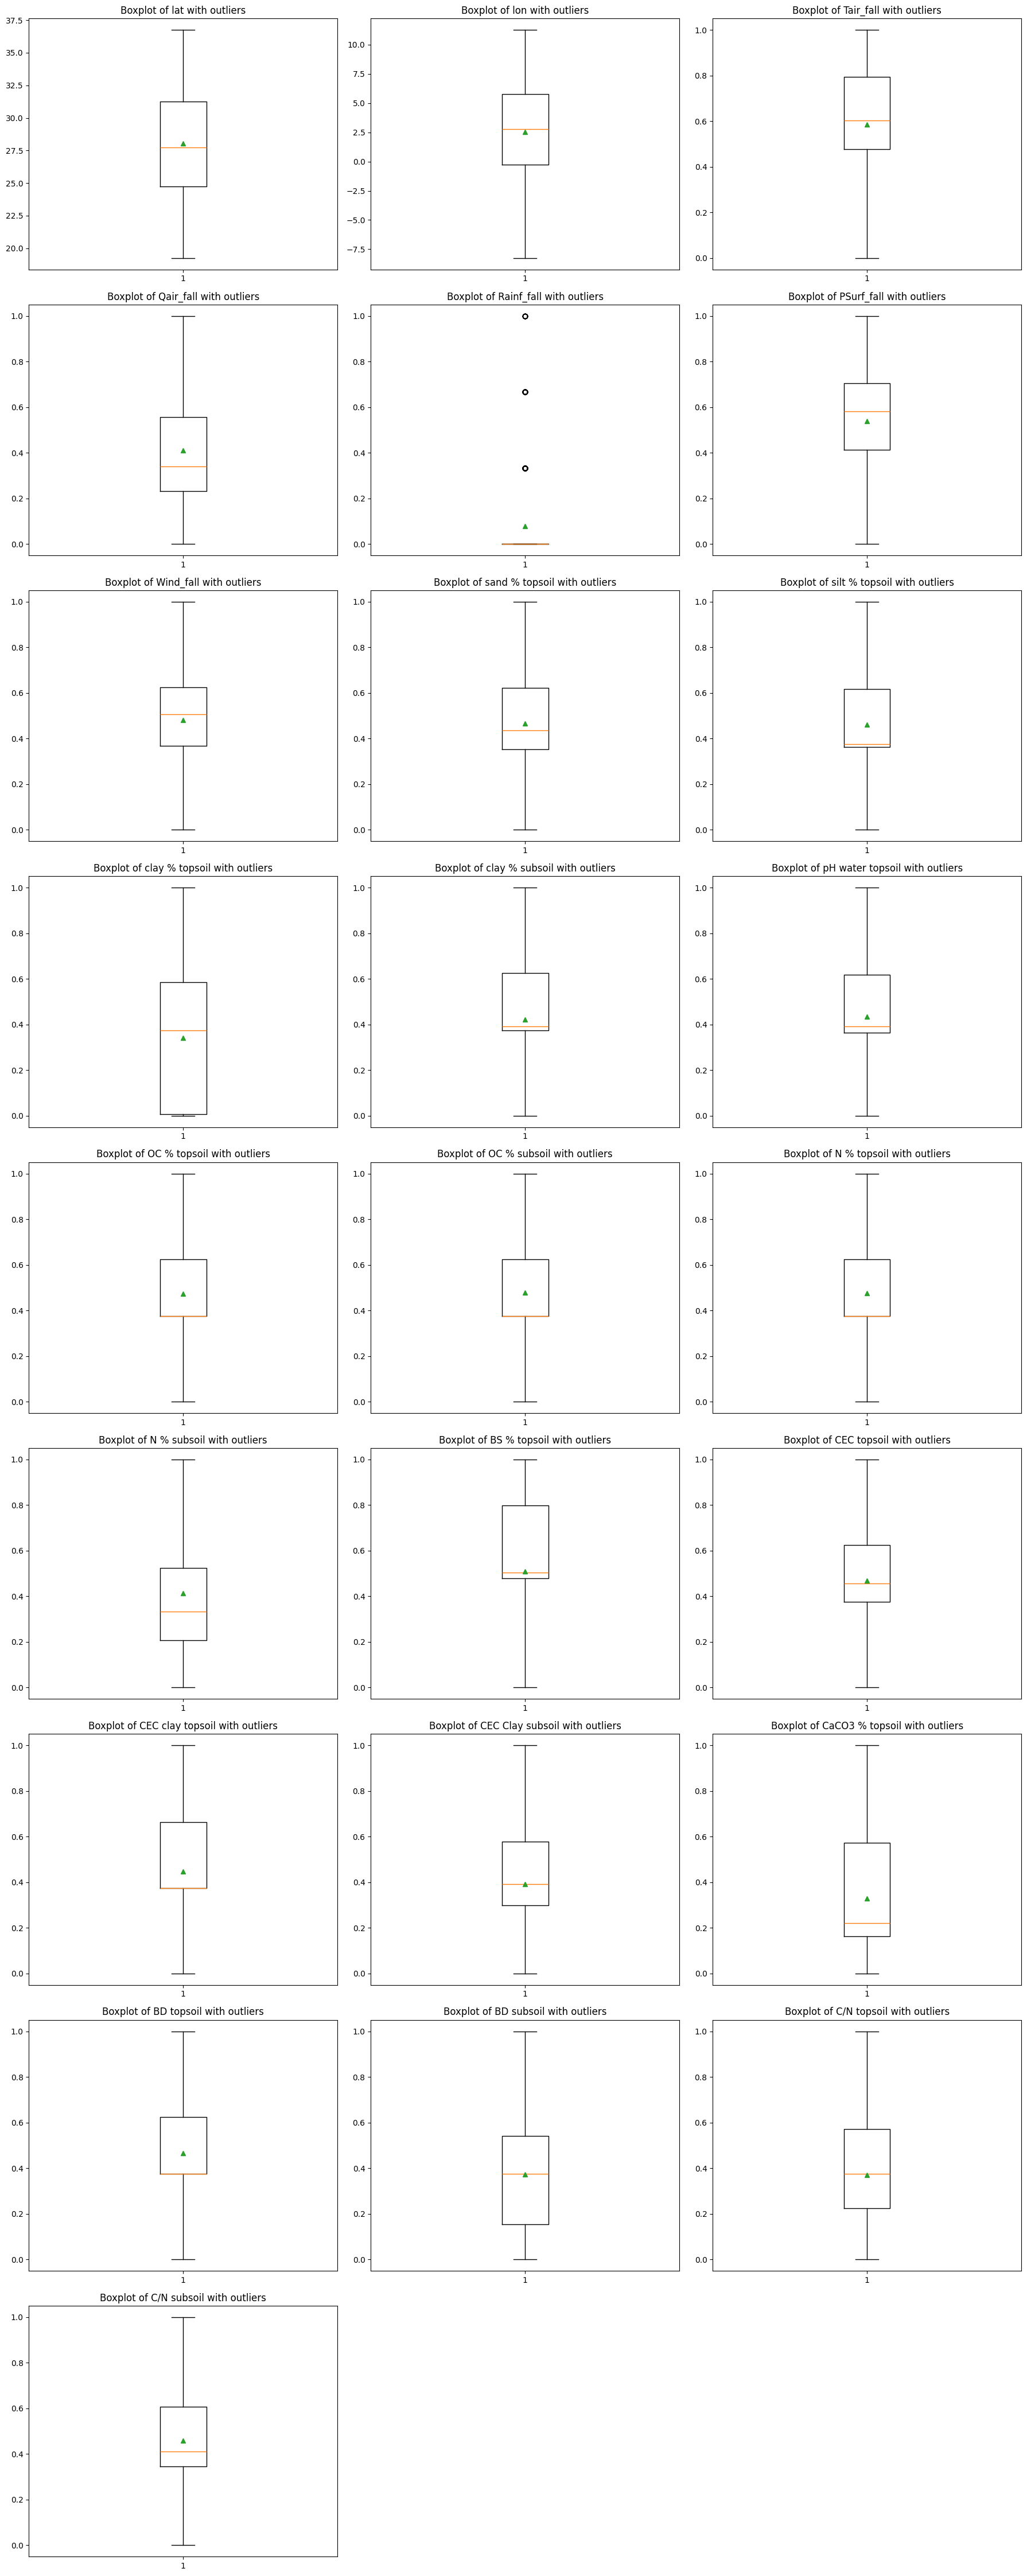

In [100]:
draw_boxplots(normalized_MM_cleaned_data)

- v. Construct histograms and visualizethe data distribution

In [101]:
def draw_histograms(dataset):
    numeric_cols = dataset.select_dtypes(include=['number']).columns # que les colonnes numériques
    data_cols = len(numeric_cols)  
    cols_per_row = 3 
    rows = math.ceil(data_cols / cols_per_row)  

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows))
    axes = axes.flatten()

    # Tracer les histogrammes pour les colonnes numériques
    for i, attribut in enumerate(numeric_cols):
        ax = axes[i]
        liste = dataset[attribut].dropna()
        # Tracer l'histogramme
        ax.hist(liste, color='blue', alpha=0.6, edgecolor='black')
        ax.set_title('Histogram of ' + attribut)
        
        # Calcul du coefficient d'asymétrie
        asymetrie = skew(liste)
        ax.text(0.35, 0.98, f"Asymmetry: {asymetrie:.2f}",
                transform=ax.transAxes, fontsize=10, ha='left', va='top')

    for j in range(data_cols, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

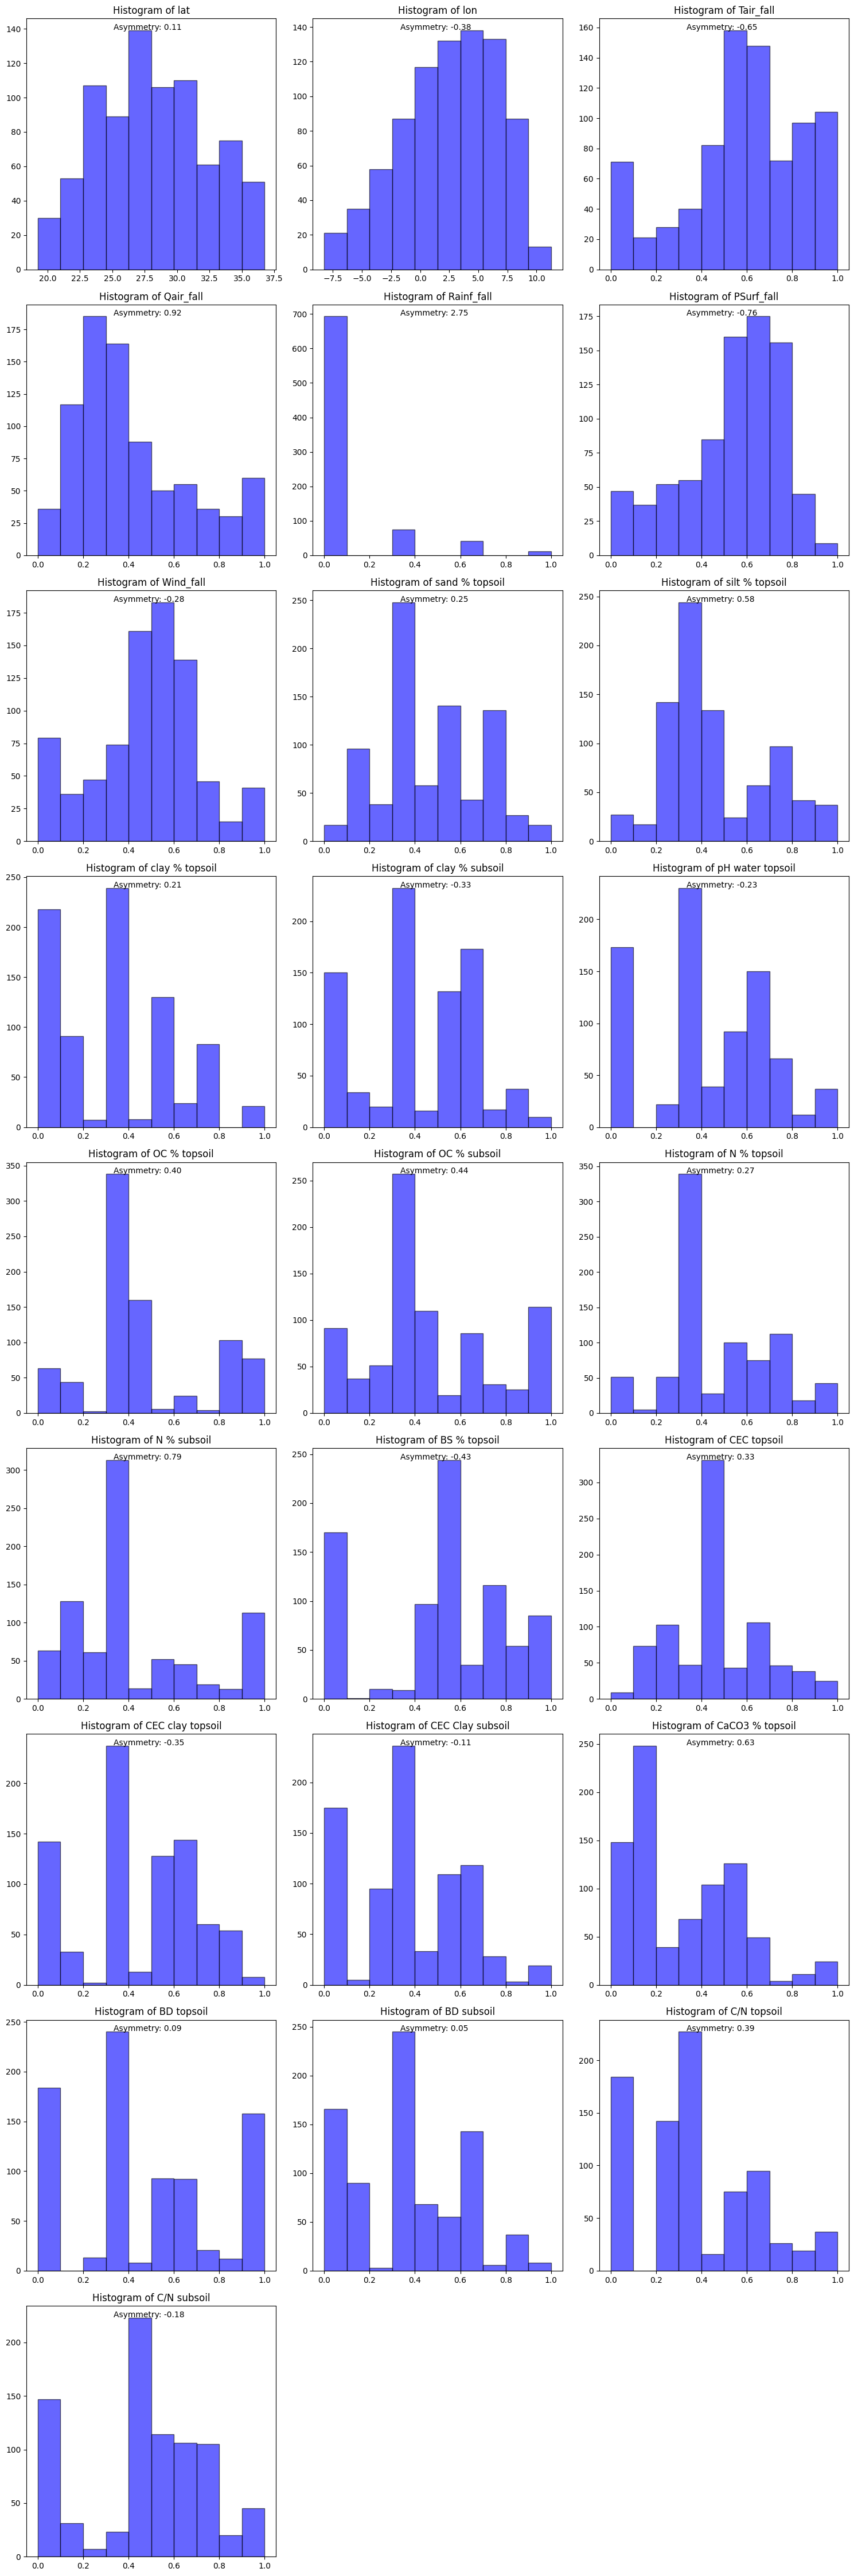

In [102]:
draw_histograms(normalized_MM_cleaned_data)

##### b. Construct and display scatter plots of the data and deduce correlations

In [106]:
# scatter plot des attributs numeriques
def is_better_pair(dataset, attribut1, attribut2):
    variance1 = dataset[attribut1].var()
    variance2 = dataset[attribut2].var()
    return variance2 > variance1  # On retourne True si la variance de attribut2 est plus grande

def draw_scatter_plot(dataset):
    pairs = []
    columns_to_exclude = ["lat", "lon", "geometry"]
    for attribut1, attribut2 in itertools.combinations(dataset.columns, 2): # itertools.combinations pour éviter les doublons dans les paires
        if attribut1 not in columns_to_exclude and attribut2 not in columns_to_exclude:
            if pd.api.types.is_numeric_dtype(dataset[attribut1]) and pd.api.types.is_numeric_dtype(dataset[attribut2]):
                if is_better_pair(dataset, attribut2, attribut1): 
                    pairs.append([attribut2, attribut1]) # on met l'attribut qui a la plus grande varience dans l'axe X
                else:
                    pairs.append([attribut1, attribut2])


    data_cols = len(pairs) 
    cols_per_row = 3 
    rows = math.ceil(data_cols / cols_per_row)  

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(17, 6 * rows))
    axes = axes.flatten()

    for i, (attribut1, attribut2) in enumerate(pairs):
        ax = axes[i]
        # Utiliser une liste de colonnes pour accéder à plusieurs colonnes
        filtred_data = dataset[[attribut1,attribut2]].dropna() # supprimer les valeurs nulles sémultanement avoir garder la meme taille des 2 attributs
        liste1 = filtred_data[attribut1]
        liste2 = filtred_data[attribut2]
        ax.scatter(liste1,liste2)
        
        # Vérifier si toutes les valeurs de liste1 sont identiques
        if len(liste1.unique()) > 1 and len(liste2.unique()) > 1:
            # Calculer la droite de régression uniquement si x n'a pas des valeurs identiques
            slope, intercept, rvalue, pvalue, stderr = stats.linregress(liste1, liste2)
            # Tracer la droite de régression
            ax.plot(liste1, slope * liste1 + intercept, color='red', label='Regression line')
            ax.annotate(f'y = {slope:.2f}x + {intercept:.2f}', 
                        xy=(0.05, 0.95), xycoords='axes fraction', 
                        fontsize=10, color='red', 
                        horizontalalignment='left', verticalalignment='top')

        ax.set_xlabel(attribut1)
        ax.set_ylabel(attribut2)
        ax.set_title(f'Scatter plot: {attribut1} vs {attribut2}')

    for j in range(data_cols, len(axes)):
        axes[j].axis('off')

    plt.show()
# il est préférable d'éliminer les outliers pour pouvoir vérifier la corrélation

# I. Regression : Decision Trees / Random Forest

In [2]:
reduced_cleaned_data = pd.read_csv("./results/reduced_cleaned_data.csv")

In [5]:
reduced_cleaned_data.shape

(821, 26)

In [74]:
reduced_cleaned_data.columns

Index(['lat', 'lon', 'Tair_fall', 'Qair_fall', 'Rainf_fall', 'PSurf_fall',
       'Wind_fall', 'geometry', 'sand % topsoil', 'silt % topsoil',
       'clay % topsoil', 'clay % subsoil', 'pH water topsoil', 'OC % topsoil',
       'OC % subsoil', 'N % topsoil', 'N % subsoil', 'BS % topsoil',
       'CEC topsoil', 'CEC clay topsoil', 'CEC Clay subsoil',
       'CaCO3 % topsoil', 'BD topsoil', 'BD subsoil', 'C/N topsoil',
       'C/N subsoil'],
      dtype='object')

### First, Spliting the dataset into 70% for training data Vs 30% for test data

In [75]:
data_regression = reduced_cleaned_data.drop(columns=["Qair_fall", "geometry"])

labels_fall = reduced_cleaned_data["Qair_fall"]

X_train_fall, X_test_fall, y_train_fall, y_test_fall = train_test_split(data_regression, labels_fall, test_size=0.3, random_state=42)

## 1. Decision Trees

### 1.1. Implemented

In [76]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature=feature  
        self.threshold=threshold  
        self.left=left  
        self.right=right  
        self.value=value  

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        X=np.array(X)
        y=np.array(y)
        self.n_features=X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root=self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats=X.shape        
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            leaf_value=self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs=np.random.choice(n_feats, self.n_features, replace=False)        
        best_feature, best_thresh=self._best_split(X, y, feat_idxs)

        if best_feature is None:
            leaf_value=self._most_common_label(y)
            return Node(value=leaf_value)
        
        left_idxs, right_idxs=self._split(X[:, best_feature], best_thresh)
        left=self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right=self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain=-1
        split_idx, split_threshold=None, None

        for feat_idx in feat_idxs:
            X_column=X[:, feat_idx]
            thresholds=np.unique(X_column)

            for thr in thresholds:                
                gain=self._variance_reduction(y, X_column, thr)

                if gain > best_gain:
                    best_gain=gain
                    split_idx=feat_idx
                    split_threshold=thr

        return split_idx, split_threshold

    def _variance_reduction(self, y, X_column, threshold):        
        parent_variance=np.var(y)
        
        left_idxs, right_idxs=self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        n=len(y)
        n_l, n_r=len(left_idxs), len(right_idxs)
        var_l, var_r=np.var(y[left_idxs]), np.var(y[right_idxs])
        weighted_variance=(n_l / n) * var_l + (n_r / n) * var_r
        
        variance_reduction=parent_variance - weighted_variance
        return variance_reduction

    def _split(self, X_column, split_thresh):
        left_idxs=np.argwhere(X_column <= split_thresh).flatten()
        right_idxs=np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):        
        return np.mean(y)

    def predict(self, X):
        X=np.array(X)
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [77]:
# 1. fall season
fall_DTree = DecisionTree(min_samples_split=5)
fall_DTree.fit(X_train_fall, y_train_fall)
predictions_fall_DT = fall_DTree.predict(X_test_fall) # 9.3s

### 1.2. Predefined

In [78]:
# 1. fall season
# dt_regressor_fall = DecisionTreeRegressor(
#     min_samples_split=10,  # Augmente le nombre minimum d'échantillons requis pour diviser un nœud
#     min_samples_leaf=5,    # Augmente le nombre minimum d'échantillons par feuille
#     max_depth=10           # Limite la profondeur de l'arbre
# )

dt_regressor_fall = DecisionTreeRegressor()
dt_regressor_fall.fit(X_train_fall, y_train_fall)
dt_y_pred_fall = dt_regressor_fall.predict(X_test_fall)

## Visualization of decesion trees

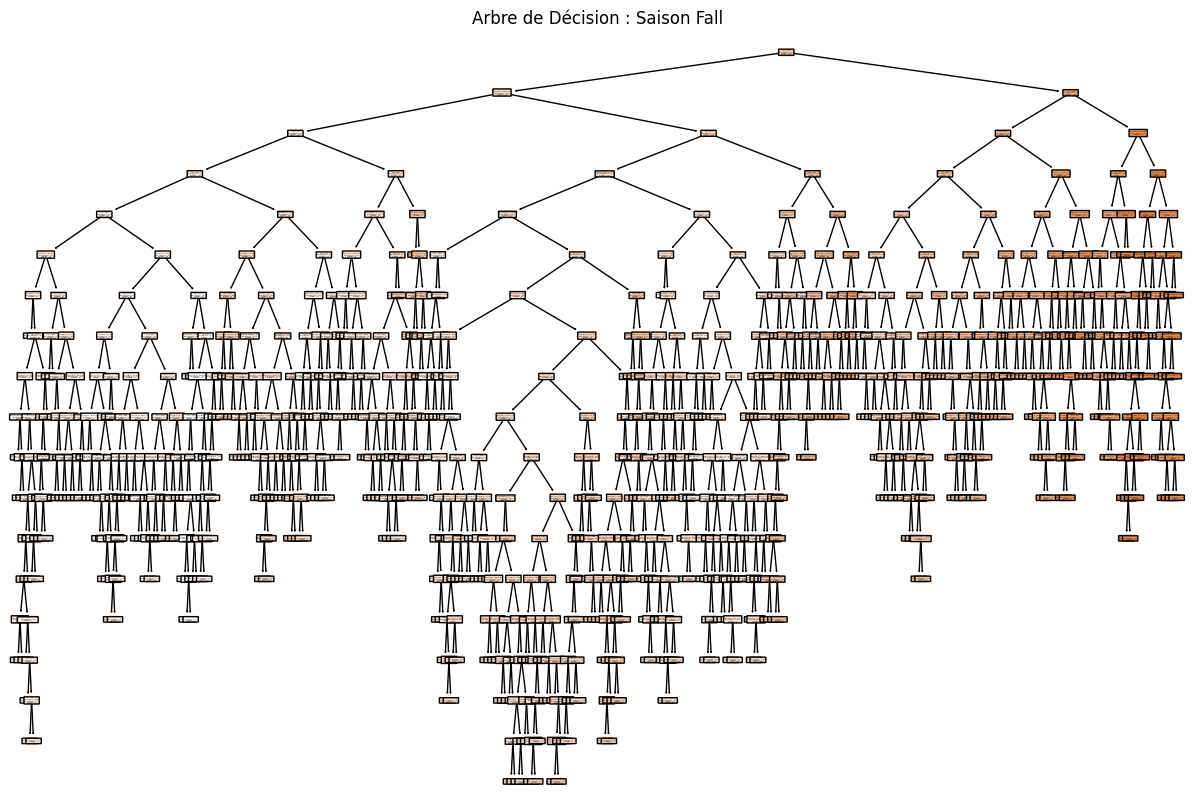

In [79]:
# Visualisation de l'arbre pour la saison Fall
plt.figure(figsize=(15, 10))
plot_tree(dt_regressor_fall, feature_names=X_train_fall.columns, filled=True, rounded=True)
plt.title("Arbre de Décision : Saison Fall")
plt.show()

## Evaluation Metrics for Regression

### 1. MAE (Mean Absolute Error) :
- Provides a clear and interpretable measure of the average error.
- Lower values indicate better performance.

### 2. MSE (Mean Squared Error) :
- Sensitive to large errors (outliers). If the MSE is significantly larger than the MAE, check your data for anomalies.

### 3. 𝑅² (Coefficient of Determination) :
- Indicates the overall quality of the model.
- An 𝑅² value close to 1 is excellent, but beware of overfitting the model.

In [81]:
results = {
    "Season": ["Fall"],
    "MAE (Imported)": [
        mean_absolute_error(y_test_fall, dt_y_pred_fall),

    ],
    "MAE (Implemented)": [
        mean_absolute_error(y_test_fall, predictions_fall_DT),
    ],
    "MSE (Imported)": [
        mean_squared_error(y_test_fall, dt_y_pred_fall),
    ],
    "MSE (Implemented)": [
        mean_squared_error(y_test_fall, predictions_fall_DT),
    ],
    "R² (Imported)": [
        r2_score(y_test_fall, dt_y_pred_fall),
    ],
    "R² (Implemented)": [
        r2_score(y_test_fall, predictions_fall_DT),
    ],
}

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Print the table
results_df

,Season,MAE (Imported),MAE (Implemented),MSE (Imported),MSE (Implemented),R² (Imported),R² (Implemented)
0,Fall,0.000189,0.000195,8.062004e-08,7.587272e-08,0.927329,0.931608


## Visualization of Predictions vs Actual Values for the Four Seasons

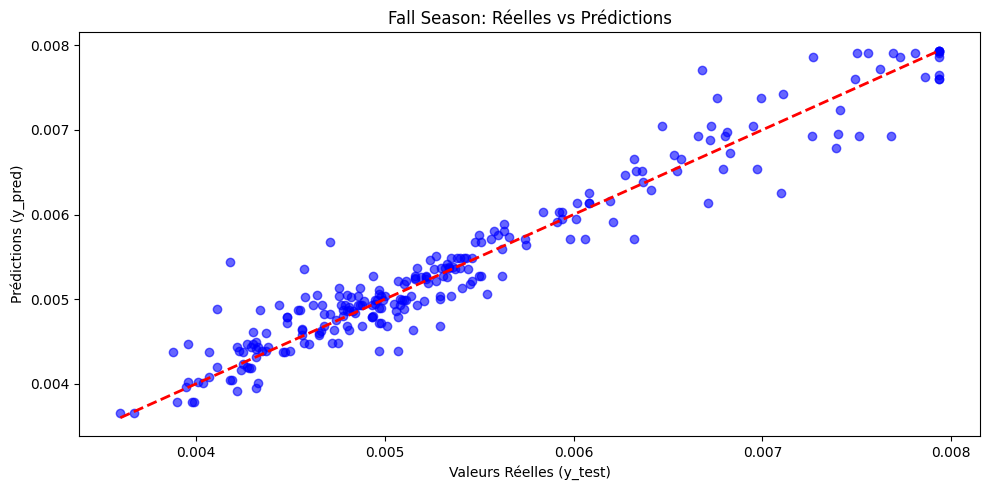

In [82]:
plt.figure(figsize=(10, 5))

# Scatter Plot pour la saison Fall
plt.subplot(1, 1, 1)
plt.scatter(y_test_fall, predictions_fall_DT, alpha=0.6, color="blue")
plt.plot([y_test_fall.min(), y_test_fall.max()], [y_test_fall.min(), y_test_fall.max()], 'r--', lw=2)
plt.xlabel("Valeurs Réelles (y_test)")
plt.ylabel("Prédictions (y_pred)")
plt.title("Fall Season: Réelles vs Prédictions")

# Ajuster les espacements entre les plots
plt.tight_layout()
plt.show()

## 2. Random Forest

### 2.1. Implemented

In [83]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

In [84]:
# 1. fall season
fall_RForest = RandomForest(n_trees=20, min_samples_split=5)
fall_RForest.fit(X_train_fall, y_train_fall)
predictions_fall_RF = fall_RForest.predict(X_test_fall) # 1m 48.6s

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### 2.2. Predefined

In [85]:
# 1. fall season
rf_regressor_fall = RandomForestRegressor()
rf_regressor_fall.fit(X_train_fall, y_train_fall)
rf_y_pred_fall = rf_regressor_fall.predict(X_test_fall)

## Evaluation Metrics for Regression

In [86]:
results = {
    "Season": ["Fall"],
    "MAE (Imported)": [
        mean_absolute_error(y_test_fall, rf_y_pred_fall),
    ],
    "MAE (Implemented)": [
        mean_absolute_error(y_test_fall, predictions_fall_RF),
    ],
    "MSE (Imported)": [
        mean_squared_error(y_test_fall, rf_y_pred_fall),
    ],
    "MSE (Implemented)": [
        mean_squared_error(y_test_fall, predictions_fall_RF),
    ],
    "R² (Imported)": [
        r2_score(y_test_fall, rf_y_pred_fall),
    ],
    "R² (Implemented)": [
        r2_score(y_test_fall, predictions_fall_RF),
    ],
}

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Print the table
results_df

,Season,MAE (Imported),MAE (Implemented),MSE (Imported),MSE (Implemented),R² (Imported),R² (Implemented)
0,Fall,0.000116,0.000166,2.363852e-08,5.647260e-08,0.978692,0.949096


## Visualization of Predictions vs Actual Values for the Four Seasons

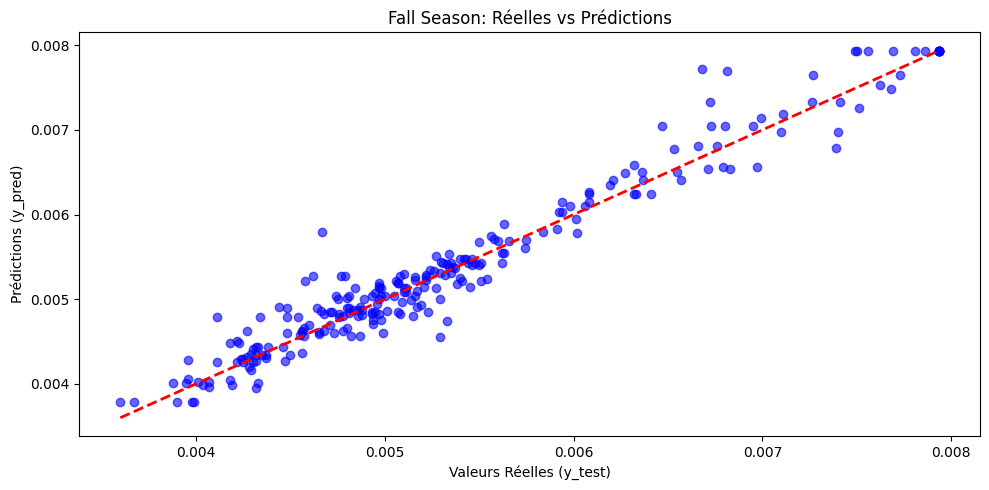

In [87]:
plt.figure(figsize=(10, 5))

# Scatter Plot pour la saison Fall
plt.subplot(1, 1, 1) 
plt.scatter(y_test_fall, predictions_fall_RF, alpha=0.6, color="blue")
plt.plot([y_test_fall.min(), y_test_fall.max()], [y_test_fall.min(), y_test_fall.max()], 'r--', lw=2)
plt.xlabel("Valeurs Réelles (y_test)")
plt.ylabel("Prédictions (y_pred)")
plt.title("Fall Season: Réelles vs Prédictions")

# Ajuster les espacements entre les plots
plt.tight_layout()
plt.show()

# J. Clustering : CLARANS / DBSCAN

In [88]:
data_clustering = pd.read_csv("./results/normalized_MM_cleaned_data.csv")
# data_clustering = pd.read_csv("./other data test/nonoutlierData.csv")
# data_clustering = pd.read_csv("./other data test/reduced_cleaned_data.csv")

In [89]:
data_clustering = data_clustering.drop(columns=["geometry"])
data_clustering.columns

Index(['lat', 'lon', 'Tair_fall', 'Qair_fall', 'Rainf_fall', 'PSurf_fall',
       'Wind_fall', 'sand % topsoil', 'silt % topsoil', 'clay % topsoil',
       'clay % subsoil', 'pH water topsoil', 'OC % topsoil', 'OC % subsoil',
       'N % topsoil', 'N % subsoil', 'BS % topsoil', 'CEC topsoil',
       'CEC clay topsoil', 'CEC Clay subsoil', 'CaCO3 % topsoil', 'BD topsoil',
       'BD subsoil', 'C/N topsoil', 'C/N subsoil'],
      dtype='object')

## 1. CLARANS (Clustering Large Applications based on RANdomized Search)

### 1.1. Implemented

In [124]:
def clarans_algo(data, number_clusters, num_local, max_neighbors):
    """
    Implémentation de l'algorithme CLARANS pour le clustering.

    :param data: ndarray, ensemble de données pour le clustering
    :param number_clusters: int, nombre de clusters (k)
    :param num_local: int, nombre de recherches locales
    :param max_neighbors: int, nombre maximum de voisins à tester par itération
    :return: tuple, (meilleurs medoids, meilleure affectation des points)
    """
    def calculate_cost(medoids, data):
        """Calcule le coût total (somme des distances entre chaque point et son médoïde le plus proche)."""
        cost = 0
        for point in data:
            distances = [np.linalg.norm(point - data[medoid]) for medoid in medoids]
            cost += min(distances)
        return cost

    def assign_points_to_medoids(medoids, data):
        """Assigne chaque point au médoïde le plus proche."""
        clusters = {medoid: [] for medoid in medoids}
        labels = []
        for idx, point in enumerate(data):
            closest_medoid = min(medoids, key=lambda m: np.linalg.norm(point - data[m]))
            clusters[closest_medoid].append(idx)
            labels.append(medoids.index(closest_medoid))
        return clusters, labels

    n_points = len(data)
    best_medoids = None
    best_cost = float('inf')

    for i in range(num_local):
        # Initialiser aléatoirement les médoïdes
        medoids = random.sample(range(n_points), number_clusters)
        current_cost = calculate_cost(medoids, data)

        improved = True
        while improved:
            improved = False
            for j in range(max_neighbors):
                # Sélectionner un médoïde courant aléatoire
                medoid_to_replace = random.choice(medoids)
                non_medoids = [idx for idx in range(n_points) if idx not in medoids]
                candidate = random.choice(non_medoids)

                # Tester un remplacement
                new_medoids = medoids[:]
                new_medoids.remove(medoid_to_replace)
                new_medoids.append(candidate)
                new_cost = calculate_cost(new_medoids, data)

                if new_cost < current_cost:
                    medoids = new_medoids
                    current_cost = new_cost
                    improved = True
                    break

        # Mettre à jour les meilleurs médoïdes si nécessaire
        if current_cost < best_cost:
            best_medoids = medoids
            best_cost = current_cost

    # Affecter les points aux meilleurs médoïdes
    best_clusters, labels = assign_points_to_medoids(best_medoids, data)
    noise_points = len([label for label in labels if label == -1])

    return best_medoids, best_clusters, labels, noise_points

In [128]:
# Paramètres de CLARANS
number_clusters = 6  # Nombre de clusters
num_local = 6        # Nombre de recherches locales
max_neighbors = 30   # Nombre de voisins aléatoires testés par itération

# Appliquer CLARANS
best_medoids, best_clusters, labels, noise_points = clarans_algo(data_clustering.values, number_clusters, num_local, max_neighbors)

# Résultats
print("Meilleurs médoïdes:", best_medoids)
print("Clusters:", best_clusters)
print(f"Nombre de bruit: {noise_points}")

print(f"nombre de clusters: {len(Counter(labels))}")
print(f"Distrebution of clusters: {Counter(labels)}")

# Filtrer les points de bruit pour le calcul du score de silhouette
filtered_data = data_clustering.values[labels != -1 ]
clarans_labels = labels[labels != -1 ]


# Calculer le score de silhouette sans les points de bruit
silhouette_avg = silhouette_score(filtered_data, clarans_labels)
print("Score de silhouette (sans bruit):", silhouette_avg)

Meilleurs médoïdes: [375, 56, 669, 260, 425, 639]
Clusters: {375: [186, 206, 209, 211, 212, 215, 216, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 546, 547, 548, 549, 550, 551, 552, 576, 578, 579, 580, 581], 56: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 8

### 1.2. Predefined

In [142]:
n_clusters = 6
metric = 'euclidean'
max_iter = 1000

KMedoids_model = KMedoids(n_clusters, metric, max_iter = max_iter, method='pam', random_state = 42)
KMedoids_model.fit(data_clustering)
# Get the labels from CLARANS
KMedoids_labels = KMedoids_model.labels_

print(f"nombre de clusters: {len(Counter(KMedoids_labels))}")
print(f"Distrebution of clusters: {Counter(KMedoids_labels)}")

nombre de clusters: 6
Distrebution of clusters: Counter({1: 154, 5: 138, 3: 138, 4: 136, 0: 128, 2: 127})


In [ ]:
# # Paramètres de CLARANS
# number_clusters = 2  # Nombre de clusters
# num_local = 1        # Nombre de recherches locales
# max_neighbors = 5    # Nombre de voisins aléatoires testés par itération

# # Appliquer CLARANS
# clarans_instance = clarans(data_clustering.values, number_clusters, num_local, max_neighbors)
# clarans_instance.process()

# # Résultat : medoids finaux et clusters
# final_medoids = clarans_instance.get_medoids()
# clusters = clarans_instance.get_clusters()

# # print("Medoids finaux :", final_medoids)
# print("Clusters :", clusters)

## Evaluation Metrics for Clustering

### 1. Davies-Bouldin Index :
Mesure la compacité et la séparation des clusters.
- Valeur : Plus faible est meilleure.
- Valeur faible : Clusters bien séparés et compacts.
- Valeur élevée : Clusters moins bien séparés ou plus dispersés.

### 2. Calinski-Harabasz Score :
- Évalue la compacité et la séparation des clusters.
- Valeur : Plus élevée indique une meilleure séparation des clusters.

### 3. Silhouette Coefficient :
Mesure l'assignation correcte des points à leurs clusters. Valeur : Entre -1 et 1.
- 1 : Parfaitement assigné.
- 0 : Point à la frontière entre deux clusters.
- < 0 : Mauvaise assignation au cluster.

In [143]:
results = {
    "davies_bouldin_score (Imported)": [
        davies_bouldin_score(data_clustering, KMedoids_labels),
    ],
    "davies_bouldin_score (Implemented)": [
        davies_bouldin_score(data_clustering, clarans_labels),
    ],
    "calinski_harabasz_score (Imported)": [
        calinski_harabasz_score(data_clustering, KMedoids_labels),
    ],
    "calinski_harabasz_score (Implemented)": [
        calinski_harabasz_score(data_clustering, clarans_labels),
    ],
    "Silhouette_Coefficient (Imported)": [
        silhouette_score(data_clustering, KMedoids_labels),
    ],
    "Silhouette_Coefficient (Implemented)": [
        silhouette_score(data_clustering, clarans_labels),
    ],
}

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Print the table
results_df

,davies_bouldin_score (Imported),davies_bouldin_score (Implemented),calinski_harabasz_score (Imported),calinski_harabasz_score (Implemented),Silhouette_Coefficient (Imported),Silhouette_Coefficient (Implemented)
0,0.927256,1.04066,673.339171,493.964109,0.332265,0.232847


## Visualization of Predicted clusters

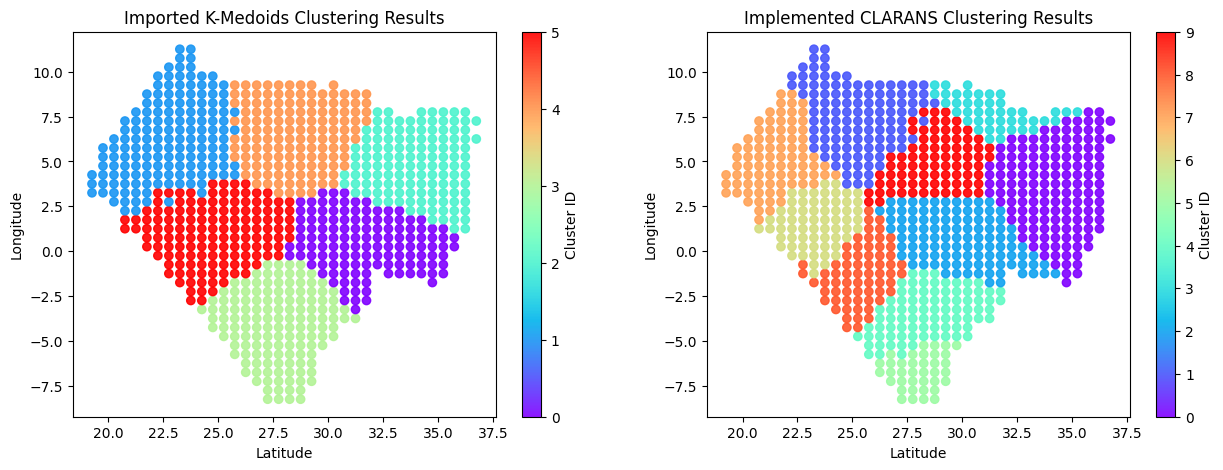

In [146]:
# Plotting the Clarans results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_clustering['lat'], data_clustering['lon'], c=KMedoids_labels, cmap='rainbow', alpha=0.9)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Imported K-Medoids Clustering Results')
plt.colorbar(label='Cluster ID')

plt.subplot(1, 2, 2)
plt.scatter(data_clustering['lat'], data_clustering['lon'], c=clarans_labels, cmap='rainbow', alpha=0.9)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Implemented CLARANS Clustering Results')
plt.colorbar(label='Cluster ID')

plt.show()

# Testing various parameters

In [ ]:
# Grille de paramètres pour CLARANS
param_grid = {
    "n_clusters": [5, 10, 15, 20],
    "max_neighbors": [10, 20, 30, 40, 50],
    "max_iter": [100, 200],
    "metric": ['euclidean', 'manhattan', 'cosine'] # 4x5x2x3= 120 combinaisons
}

# Grille de résultats
clarans_results = {
    "n_clusters": [],
    "metric": [],
    "max_neighbors": [],
    "max_iter": [],
    "davies_bouldin_score (Imported)": [],
    "davies_bouldin_score (Implemented)": [],
    "calinski_harabasz_score (Imported)": [],
    "calinski_harabasz_score (Implemented)": [],
    "silhouette_score (Imported)": [],
    "silhouette_score (Implemented)": [],
}

# Tester CLARANS avec toutes les combinaisons de paramètres
for n_clusters in param_grid["n_clusters"]:
    for max_neighbors in param_grid["max_neighbors"]:
        for max_iter in param_grid["max_iter"]:
            for metric in param_grid["metric"]:
                print(f"Testing CLARANS with n_clusters={n_clusters}, max_neighbors={max_neighbors}, max_iter={max_iter}, metric={metric}")

                # CLARANS implémenté manuellement
                # Obtenir les meilleurs médodes, le coût et les clusters
                try:
                    best_medoids, best_cost, clusters = clarans_algo(
                        data_clustering_values,  # Votre dataset sous forme de tableau NumPy
                        n_clusters, max_neighbors, metric, max_iter
                    )

                    # Générer les labels pour l'implémentation manuelle
                    implemented_clarans_labels = []
                    for point in data_clustering_values:
                        closest_medoid = min(best_medoids, key=lambda medoid: np.linalg.norm(np.array(point) - np.array(medoid)))
                        cluster_label = [i for i, medoid in enumerate(best_medoids) if np.array_equal(medoid, closest_medoid)][0]
                        implemented_clarans_labels.append(cluster_label)
                except Exception as e:
                    print(f"Error in manual CLARANS implementation: {e}")
                    implemented_clarans_labels = [-1] * len(data_clustering_values)

                # CLARANS/K-Medoids pré-implémenté
                try:
                    KMedoids_model = KMedoids(
                        n_clusters=n_clusters, metric=metric, max_iter=max_iter, method='pam', random_state=42
                    )
                    imported_clarans_clusters = KMedoids_model.fit_predict(data_clustering_values)
                except Exception as e:
                    print(f"Error in imported KMedoids implementation: {e}")
                    imported_clarans_clusters = [-1] * len(data_clustering_values)

                # Calcul des scores si le nombre de clusters valides est suffisant
                clarans_results["davies_bouldin_score (Imported)"].append(
                    davies_bouldin_score(data_clustering_values, imported_clarans_clusters)
                    if len(set(imported_clarans_clusters)) > 1 else np.nan
                )
                clarans_results["davies_bouldin_score (Implemented)"].append(
                    davies_bouldin_score(data_clustering_values, implemented_clarans_labels)
                    if len(set(implemented_clarans_labels)) > 1 else np.nan
                )
                clarans_results["calinski_harabasz_score (Imported)"].append(
                    calinski_harabasz_score(data_clustering_values, imported_clarans_clusters)
                    if len(set(imported_clarans_clusters)) > 1 else np.nan
                )
                clarans_results["calinski_harabasz_score (Implemented)"].append(
                    calinski_harabasz_score(data_clustering_values, implemented_clarans_labels)
                    if len(set(implemented_clarans_labels)) > 1 else np.nan
                )
                clarans_results["silhouette_score (Imported)"].append(
                    silhouette_score(data_clustering_values, imported_clarans_clusters)
                    if len(set(imported_clarans_clusters)) > 1 else np.nan
                )
                clarans_results["silhouette_score (Implemented)"].append(
                    silhouette_score(data_clustering_values, implemented_clarans_labels)
                    if len(set(implemented_clarans_labels)) > 1 else np.nan
                )

                # Ajouter les paramètres utilisés
                clarans_results["n_clusters"].append(n_clusters)
                clarans_results["metric"].append(metric)
                clarans_results["max_neighbors"].append(max_neighbors)
                clarans_results["max_iter"].append(max_iter)

                # Visualisation des résultats CLARANS (si clusters valides)
                if len(set(implemented_clarans_labels)) > 1:
                    plt.figure(figsize=(15, 5))
                    
                    # Résultats pour CLARANS importé
                    plt.subplot(1, 2, 1)
                    plt.scatter(data_clustering['lat'], data_clustering['lon'], c=imported_clarans_clusters, cmap='rainbow', alpha=0.9)
                    plt.xlabel('Latitude')
                    plt.ylabel('Longitude')
                    plt.title(f'Imported CLARANS Clustering Results\n(n_clusters={n_clusters}, max_neighbors={max_neighbors}, metric={metric})')
                    plt.colorbar(label='Cluster ID')
                    
                    # Résultats pour CLARANS implémenté manuellement
                    plt.subplot(1, 2, 2)
                    plt.scatter(data_clustering['lat'], data_clustering['lon'], c=implemented_clarans_labels, cmap='rainbow', alpha=0.9)
                    plt.xlabel('Latitude')
                    plt.ylabel('Longitude')
                    plt.title(f'Implemented CLARANS Clustering Results\n(n_clusters={n_clusters}, max_neighbors={max_neighbors}, metric={metric})')
                    plt.colorbar(label='Cluster ID')
                    
                    plt.tight_layout()
                    plt.savefig(f"clarans_results_n_clusters_{n_clusters}_max_neighbors_{max_neighbors}_metric_{metric}.png")
                    # plt.show()

                # Réduction de dimension avec PCA pour visualiser les clusters
                pca = PCA(n_components=2)
                data_pca = pca.fit_transform(data_clustering_values)

                if len(set(implemented_clarans_labels)) > 1:
                    plt.figure(figsize=(15, 5))
                    plt.subplot(1, 2, 1)
                    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=imported_clarans_clusters, cmap='rainbow', alpha=0.9)
                    plt.title(f'PCA - Imported CLARANS (n_clusters={n_clusters}, metric={metric})')
                    plt.colorbar(label='Cluster ID')

                    plt.subplot(1, 2, 2)
                    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=implemented_clarans_labels, cmap='rainbow', alpha=0.9)
                    plt.title(f'PCA - Implemented CLARANS (n_clusters={n_clusters}, metric={metric})')
                    plt.colorbar(label='Cluster ID')
                    
                    plt.savefig(f"PCA clarans_results_n_clusters_{n_clusters}_max_neighbors_{max_neighbors}_metric_{metric}.png")
                    plt.tight_layout()
                    # plt.show()

# Sauvegarder les résultats dans un CSV
clarans_results_df = pd.DataFrame(clarans_results)
clarans_results_df.to_csv('clarans_results_grid_search.csv', index=False)

print("CLARANS Grid Search Complete!") # 240m 16.s

In [245]:
clarans_results_df = pd.DataFrame(clarans_results)
clarans_results_df.to_csv('clarans_results_grid_search.csv', index=False)

## 2. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

### 2.1. Implemented

In [35]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def manhattan_distance(point1, point2):
    return np.sum(np.abs(point1 - point2))

def cosine_distance(point1, point2):
    return 1 - np.dot(point1, point2) / (np.linalg.norm(point1) * np.linalg.norm(point2))

def region_query(data, point_idx, eps, distance_func):
    neighbors = []
    for idx in range(len(data)):
        if distance_func(data.iloc[point_idx].to_numpy(), data.iloc[idx].to_numpy()) <= eps:
            neighbors.append(idx)
    return neighbors


def expand_cluster(data, labels, point_idx, cluster_id, neighbors, eps, min_samples, distance_func):
    labels[point_idx] = cluster_id
    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]
        if labels[neighbor_idx] == -1:  # Change noise to border point
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == 0:  # Unvisited point
            labels[neighbor_idx] = cluster_id
            new_neighbors = region_query(data, neighbor_idx, eps, distance_func)
            if len(new_neighbors) >= min_samples:
                neighbors += new_neighbors
        i += 1

def dbscan_algo(data, eps, min_samples, distance_metric=distance_metric):
    if distance_metric == 'euclidean':
        distance_func = euclidean_distance
    elif distance_metric == 'manhattan':
        distance_func = manhattan_distance
    elif distance_metric == 'cosine':
        distance_func = cosine_distance
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.zeros(len(data), dtype=int)  # 0: unvisited, -1: noise, positive integers: cluster IDs
    cluster_id = 0

    for point_idx in range(len(data)):
        if labels[point_idx] != 0:
            continue

        neighbors = region_query(data, point_idx, eps, distance_func)

        if len(neighbors) < min_samples:
            labels[point_idx] = -1  # Mark as noise
        else:
            cluster_id += 1
            expand_cluster(data, labels, point_idx, cluster_id, neighbors, eps, min_samples, distance_func)

    return labels

In [36]:
eps = 0.8 # Maximum distance between two samples
min_samples = 4 # Number of samples in a neighborhood
distance_metric='manhattan' # Distance metric to use for the algorithm

dbscan_all_labels = dbscan_algo(data_clustering, eps, min_samples, distance_metric) # 1m 14.3s

# On excluant les points de bruit
valid_data_clustering = data_clustering[dbscan_all_labels != -1]
dbscan_labels = dbscan_all_labels[dbscan_all_labels != -1]

print(f"Number of clusters with noise: {len(Counter(dbscan_all_labels))}")
print("Number of clusters: ", len(Counter(dbscan_labels)))
# print("Number of clusters: ", len(np.unique(dbscan_all_labels)) - (1 if -1 in np.unique(dbscan_all_labels) else 0))
print(f"Distrebution of clusters: {Counter(dbscan_all_labels)}")  

if len(set(dbscan_labels)) > 1:
    print(silhouette_score(valid_data_clustering, dbscan_labels))

Number of clusters with noise: 32
Number of clusters:  31
Distrebution of clusters: Counter({1: 217, 2: 95, 6: 92, -1: 85, 17: 78, 14: 66, 8: 25, 3: 23, 10: 16, 13: 13, 27: 11, 21: 10, 30: 10, 4: 9, 7: 9, 24: 9, 28: 9, 18: 8, 5: 7, 11: 7, 22: 7, 12: 6, 9: 5, 16: 5, 19: 5, 25: 5, 15: 4, 20: 4, 23: 4, 26: 4, 29: 4, 31: 4})
0.2508715462915947


### 2.2. Predefined

In [48]:
eps = 0.9 # Maximum distance between two samples
min_samples = 2 # Number of samples in a neighborhood
metric = "manhattan" # Distance metric to use for the algorithm

dbscan_model = DBSCAN(eps=eps, min_samples= min_samples, metric=metric)
"""
    "euclidean" : Distance Euclidienne (par défaut)
    "manhattan" : Distance Manhattan
    "cosine" : Distance Cosinus
    "precomputed" : Matrice de distances pré-calculée
    "minkowski" : Distance Minkowski
    "hamming" : Distance Hamming
    "chebyshev" : Distance Chebyshev
"""
dbscan_all_clusters = dbscan_model.fit_predict(data_clustering)

# On excluant les points de bruit
valid_data_clustering = data_clustering[dbscan_all_clusters != -1]
dbscan_clusters = dbscan_all_clusters[dbscan_all_clusters != -1]

print(f"Numbre of clusters with noise: {len(Counter(dbscan_all_clusters))}")
print(f"Numbre of clusters with noise: {len(Counter(dbscan_clusters))}")
print(f"Distrebution of clusters: {Counter(dbscan_all_clusters)}")
#  (MANHATTEN 0.55 3)  0.55 2   0.7 5 0.6 5 0.6 4 0.6 3  0.9 7  0.9 8   0.9 9 1.0 4 0.75 5 

if len(set(dbscan_clusters)) > 1:
    print(silhouette_score(valid_data_clustering, dbscan_clusters))

Numbre of clusters with noise: 40
Numbre of clusters with noise: 39
Distrebution of clusters: Counter({2: 223, 0: 121, 6: 94, 18: 86, 16: 66, -1: 33, 9: 29, 3: 23, 13: 16, 15: 13, 27: 12, 30: 11, 5: 10, 36: 10, 4: 9, 7: 9, 10: 8, 19: 8, 8: 5, 12: 5, 14: 5, 17: 5, 21: 5, 25: 5, 20: 4, 23: 4, 26: 4, 37: 4, 11: 3, 22: 3, 28: 3, 29: 3, 31: 3, 1: 2, 24: 2, 32: 2, 33: 2, 34: 2, 35: 2, 38: 2})
0.26023507802323265


## Evaluation Metrics for Clustering

In [38]:
results = {
    "davies_bouldin_score (Imported)": [
        davies_bouldin_score(valid_data_clustering, dbscan_clusters),
    ],
    "davies_bouldin_score (Implemented)": [
        davies_bouldin_score(valid_data_clustering, dbscan_labels),
    ],
    "calinski_harabasz_score (Imported)": [
        calinski_harabasz_score(valid_data_clustering, dbscan_clusters),
    ],
    "calinski_harabasz_score (Implemented)": [
        calinski_harabasz_score(valid_data_clustering, dbscan_labels),
    ],
    "silhouette_score (Imported)": [
        silhouette_score(valid_data_clustering, dbscan_clusters),
    ],
    "silhouette_score (Implemented)": [
        silhouette_score(valid_data_clustering, dbscan_labels),
    ],
}

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Print the table
results_df

,davies_bouldin_score (Imported),davies_bouldin_score (Implemented),calinski_harabasz_score (Imported),calinski_harabasz_score (Implemented),silhouette_score (Imported),silhouette_score (Implemented)
0,0.917812,0.917812,119.858163,119.858163,0.250872,0.250872


## Visualization of Predicted clusters

KeyError: 'lon'

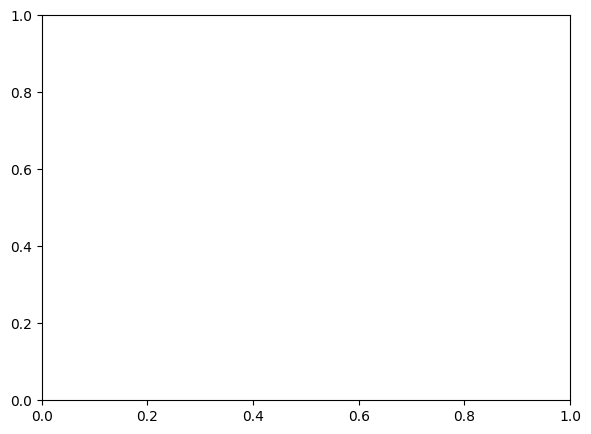

In [39]:
# Plotting the DBSCAN results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_clustering['lat'], data_clustering['lon'], c=dbscan_all_clusters, cmap='rainbow', alpha=0.9)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Imported DBSCAN Clustering Results')
plt.colorbar(label='Cluster ID')

plt.subplot(1, 2, 2)
plt.scatter(data_clustering['lat'], data_clustering['lon'], c=dbscan_all_labels, cmap='rainbow', alpha=0.9)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Implemented DBSCAN Clustering Results')
plt.colorbar(label='Cluster ID')

plt.show()

## Testing Various parameters 

In [ ]:
# Grille de paramètres pour DBSCAN
param_grid = {
    "eps": [0.55, 0.6, 0.7, 0.8, 0.9, 1],
    "min_samples": [2, 3, 4, 5, 6],
    "metric": ['euclidean', 'manhattan', 'cosine']  # 6×5×3=90 combinaisons
}
    

# Grille de résultats
dbscan_results = {
    "eps": [],
    "min_samples": [],
    "metric": [],
    "n_clusters (Imported)": [],
    "n_clusters (Implemented)": [],
    "n_noise (Imported)": [],
    "n_noise (Implemented)": [],
    "davies_bouldin_score (Imported)": [],
    "davies_bouldin_score (Implemented)": [],
    "calinski_harabasz_score (Imported)": [],
    "calinski_harabasz_score (Implemented)": [],
    "silhouette_score (Imported)": [],
    "silhouette_score (Implemented)": [],
}

# Tester DBSCAN avec toutes les combinaisons de paramètres
for eps in param_grid["eps"]:
    for min_samples in param_grid["min_samples"]:
        for metric in param_grid["metric"]:
            print(f"Testing DBSCAN with eps={eps}, min_samples={min_samples}, metric={metric}")
            
            # DBSCAN implémenté manuellement
            implemented_dbscan_labels = dbscan_algo(data_clustering, eps, min_samples, metric)
            # On excluant les points de bruit
            # valid_data_clustering = data_clustering[implemented_dbscan_labels != -1]
            # db_labels = implemented_dbscan_labels[implemented_dbscan_labels != -1]
                        
            # DBSCAN pré-implémenté
            dbscan_pre = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            imported_dbscan_clusters = dbscan_pre.fit_predict(data_clustering)

            # Vérification : Nombre de clusters détectés (sans compter les bruits -1)
            imported_unique_labels = np.unique(imported_dbscan_clusters)
            implemented_unique_labels = np.unique(implemented_dbscan_labels)

            imported_valid_clusters = len(imported_unique_labels) - (1 if -1 in imported_unique_labels else 0)
            implemented_valid_clusters = len(implemented_unique_labels) - (1 if -1 in implemented_unique_labels else 0)

            # Initialiser les scores à NaN (au cas où ils ne sont pas calculables)
            dbscan_results["davies_bouldin_score (Imported)"].append(np.nan)
            dbscan_results["davies_bouldin_score (Implemented)"].append(np.nan)
            dbscan_results["calinski_harabasz_score (Imported)"].append(np.nan)
            dbscan_results["calinski_harabasz_score (Implemented)"].append(np.nan)
            dbscan_results["silhouette_score (Imported)"].append(np.nan)
            dbscan_results["silhouette_score (Implemented)"].append(np.nan)

            if imported_valid_clusters > 1:  # Vérification pour DBSCAN importé
                dbscan_results["davies_bouldin_score (Imported)"][-1] = davies_bouldin_score(data_clustering, imported_dbscan_clusters)
                dbscan_results["calinski_harabasz_score (Imported)"][-1] = calinski_harabasz_score(data_clustering, imported_dbscan_clusters)
                dbscan_results["silhouette_score (Imported)"][-1] = silhouette_score(data_clustering, imported_dbscan_clusters)

            if implemented_valid_clusters > 1:  # Vérification pour DBSCAN implémenté
                dbscan_results["davies_bouldin_score (Implemented)"][-1] = davies_bouldin_score(data_clustering, implemented_dbscan_labels)
                dbscan_results["calinski_harabasz_score (Implemented)"][-1] = calinski_harabasz_score(data_clustering, implemented_dbscan_labels)
                dbscan_results["silhouette_score (Implemented)"][-1] = silhouette_score(data_clustering, implemented_dbscan_labels)

            # Ajouter les paramètres utilisés
            dbscan_results["eps"].append(eps)
            dbscan_results["min_samples"].append(min_samples)
            dbscan_results["metric"].append(metric)

            # Visualisation des résultats DBSCAN (si clusters valides)
            if imported_valid_clusters > 1:
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 2, 1)
                plt.scatter(data_clustering['lat'], data_clustering['lon'], c=imported_dbscan_clusters, cmap='rainbow', alpha=0.9)
                plt.xlabel('Latitude')
                plt.ylabel('Longitude')
                plt.title(f'Imported DBSCAN Clustering Results\n(eps={eps}, min_samples={min_samples}, metric={metric})')
                plt.colorbar(label='Cluster ID')

                plt.subplot(1, 2, 2)
                plt.scatter(data_clustering['lat'], data_clustering['lon'], c=implemented_dbscan_labels, cmap='rainbow', alpha=0.9)
                plt.xlabel('Latitude')
                plt.ylabel('Longitude')
                plt.title(f'Implemented DBSCAN Clustering Results\n(eps={eps}, min_samples={min_samples}, metric={metric})')
                plt.colorbar(label='Cluster ID')

                plt.tight_layout()
                plt.savefig(f"dbscan_results_eps_{eps}_min_samples_{min_samples}_metric_{metric}.png")
                # plt.show()

            # Réduction de dimension avec PCA pour visualiser les clusters
            pca = PCA(n_components=2)
            data_pca = pca.fit_transform(data_clustering[['lat', 'lon']])

            if implemented_valid_clusters > 1:
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 2, 1)
                plt.scatter(data_pca[:, 0], data_pca[:, 1], c=imported_dbscan_clusters, cmap='rainbow', alpha=0.9) # this one dans la sortie
                plt.title(f'PCA - Imported DBSCAN Clustering Results\n(eps={eps}, min_samples={min_samples}, metric={metric})')
                plt.colorbar(label='Cluster ID')
                plt.xlabel('PCA Component 1')
                plt.ylabel('PCA Component 2')

                plt.subplot(1, 2, 2)
                plt.scatter(data_pca[:, 0], data_pca[:, 1], c=implemented_dbscan_labels, cmap='rainbow', alpha=0.9)
                plt.title(f'PCA - Implemented DBSCAN Clustering Results\n(eps={eps}, min_samples={min_samples}, metric={metric})')
                plt.colorbar(label='Cluster ID')
                plt.xlabel('PCA Component 1')
                plt.ylabel('PCA Component 2')
                
                plt.savefig(f"pca_dbscan_results_eps_{eps}_min_samples_{min_samples}_metric_{metric}.png")
                plt.tight_layout()  
                # plt.show()

# Sauvegarder les résultats dans un CSV
dbscan_results_df = pd.DataFrame(dbscan_results)
dbscan_results_df.to_csv('dbscan_results_grid_search.csv', index=False)

print("DBSCAN Grid Search Complete!")  # 102m 15.6s